In [1]:
import pandas as pd
import numpy as np
import re
import math

import nltk
import nltk.corpus
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import seaborn as sns 
from collections import Counter
from wordcloud import WordCloud

#supressing warnings
import warnings
warnings.filterwarnings('ignore')

#importing tensorflow and keras packages
from keras.models import Sequential
from keras.layers import Dense, LSTM
from tensorflow.keras.layers import Dropout
import tensorflow as tf
from tensorflow import keras
from scikeras.wrappers import KerasRegressor

#importing sklearn packages
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score

#loading in evaluation metrics from statsmodels
from statsmodels.tools.eval_measures import mse, rmse


#time-series analysis
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.arima.model import ARIMA
from dateutil.relativedelta import relativedelta
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, plot_predict
import pmdarima as pm
from pmdarima.arima import ADFTest
from pandas.plotting import autocorrelation_plot
import statsmodels.api as sm

In [2]:
#pip install wordcloud 

### Section 1: Loading the dataset

In [3]:
tweets_df = pd.read_csv("cass_processed_tweets.csv",header=None)

In [4]:
tweets_df.head()

,0,1,2,3
0,1569400,2009-06-16T05:49:23.000+01:00,congrats mod gig hopefully doesnt piss much lo...,2009-06-16
1,1441571,2009-06-07T05:44:59.000+01:00,ive got awesome friend,2009-06-07
2,16266,2009-04-19T04:51:33.000+01:00,great friend grimeys record hearing mutemath p...,2009-04-19
3,1010720,2009-05-22T11:21:21.000+01:00,good morning minute lunch dont time fly hungov...,2009-05-22
4,58483,2009-05-03T10:44:37.000+01:00,think may slowly dying,2009-05-03


In [5]:
tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1592156 entries, 0 to 1592155
Data columns (total 4 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   0       1592156 non-null  int64 
 1   1       1592156 non-null  object
 2   2       1592156 non-null  object
 3   3       1592156 non-null  object
dtypes: int64(1), object(3)
memory usage: 48.6+ MB


In [6]:
#renaming columns to more appropriate names
tweets_df.rename(columns={0:'index',1:'datetime',2:'text',3:'date'},inplace=True)

In [7]:
#tweets_df[tweets_df['text'].isnull()]

Due to the nature of processing in pyspark, where parallelisation and partitioning of the dataframes cause the data to shuffled, I must resort the data based off the index column:

In [8]:
#resorting data based on the index column 
tweets_df = tweets_df.sort_values('index')

In [9]:
#once the dataframe is correctly sorted, I will remove the unneccessary index columns
tweets_df = tweets_df.reset_index().drop(columns=['level_0','index'])

In [10]:
tweets_df.head()

,datetime,text,date
0,2009-04-07T06:19:45.000+01:00,awww thats bummer shoulda got david carr third...,2009-04-07
1,2009-04-07T06:19:49.000+01:00,upset cant update facebook texting might cry r...,2009-04-07
2,2009-04-07T06:19:53.000+01:00,dived many time ball managed save rest go bound,2009-04-07
3,2009-04-07T06:19:57.000+01:00,whole body feel itchy like fire,2009-04-07
4,2009-04-07T06:19:57.000+01:00,behaving im mad cant see,2009-04-07


In [11]:
tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1592156 entries, 0 to 1592155
Data columns (total 3 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   datetime  1592156 non-null  object
 1   text      1592156 non-null  object
 2   date      1592156 non-null  object
dtypes: object(3)
memory usage: 36.4+ MB


In [12]:
#checking for null values
tweets_df.isnull().sum()

datetime    0
text        0
date        0
dtype: int64

Recasting datatime from an object to a datetime value and the date field to a date data type:

In [13]:
tweets_df['datetime'] = pd.to_datetime(tweets_df['datetime'])

In [14]:
tweets_df['date'] = pd.to_datetime(tweets_df['date']).dt.date

In [15]:
tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1592156 entries, 0 to 1592155
Data columns (total 3 columns):
 #   Column    Non-Null Count    Dtype                               
---  ------    --------------    -----                               
 0   datetime  1592156 non-null  datetime64[ns, pytz.FixedOffset(60)]
 1   text      1592156 non-null  object                              
 2   date      1592156 non-null  object                              
dtypes: datetime64[ns, pytz.FixedOffset(60)](1), object(2)
memory usage: 36.4+ MB


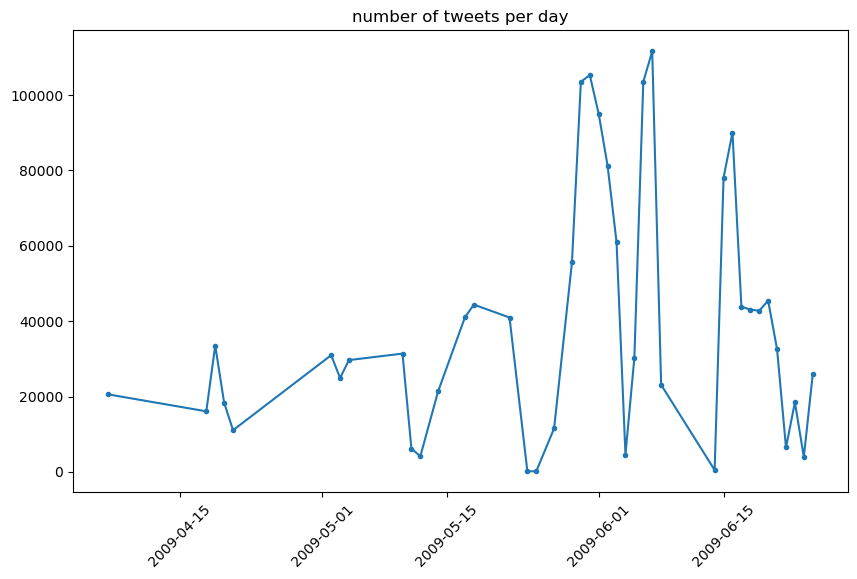

In [16]:
##plotting the number of tweets per day
plt.figure(figsize=(10,6))
plt.title("number of tweets per day")
plt.plot(tweets_df.groupby('date').size(), marker='.')
plt.xticks(rotation=45)
plt.show()

In [17]:
tweets_df.head()

,datetime,text,date
0,2009-04-07 06:19:45+01:00,awww thats bummer shoulda got david carr third...,2009-04-07
1,2009-04-07 06:19:49+01:00,upset cant update facebook texting might cry r...,2009-04-07
2,2009-04-07 06:19:53+01:00,dived many time ball managed save rest go bound,2009-04-07
3,2009-04-07 06:19:57+01:00,whole body feel itchy like fire,2009-04-07
4,2009-04-07 06:19:57+01:00,behaving im mad cant see,2009-04-07


In [18]:
##=======================================================================================================##

## Section 2: Sentiment Analysis

- VADER (Valence Aware Dictionary and sEntiment Reasone) was chosen to perform the sentiment analysis on the tweets for this research project. VADER was chosen as it is generally considered as very good at identifying sentiment from social media text. The lexical approach is quick to implement as it doesnt require any training data and it is efficient at analyzing large datasets.
- VADER uses a dictionary of words and rules to determine the sentiment of a piece of text. It uses a valence score for each word to determine its positivity or negativity.
- The **SentimentIntensityAnalyzer** class provides a method called polarity_scores() that takes a piece of text as input and returns a dictionary containing the sentiment scores for the text. The dictionary contains four keys: neg, neu, pos, and compound.
- The compound score will be used for modelling as it represents the overall sentiment score (ranging from -1, highly negative, to +1, highly positive).

ref: https://pypi.org/project/vaderSentiment/

In [19]:
# Create a SentimentIntensityAnalyzer object
sia = SentimentIntensityAnalyzer()

In [20]:
#first function is designed to identify is the sentiment is negative,postive or neutral based on a defined threshold
def get_sentiment(polarity, pos_threshold=0.05, neg_threshold=-0.05):    
    sentiment = "neutral"

    if(polarity >= pos_threshold):
        sentiment = "positive"

    elif(polarity <= neg_threshold):
        sentiment = "negative"

    return sentiment

#### applying polarity_scores to all text in the dataframe and extracting the 4 relevant sentiment scores:

In [21]:
tweets_df['compound'] = tweets_df['text'].apply(lambda x: sia.polarity_scores(x)['compound'])

In [22]:
tweets_df['pos_score'] = tweets_df['text'].apply(lambda x: sia.polarity_scores(x)['pos'])

In [23]:
tweets_df['neg_score'] = tweets_df['text'].apply(lambda x: sia.polarity_scores(x)['neg'])

In [24]:
tweets_df['neu_score'] = tweets_df['text'].apply(lambda x: sia.polarity_scores(x)['neu'])

In [25]:
tweets_df['sentiment'] = tweets_df['compound'].apply(get_sentiment)

In [26]:
tweets_df.head()

,datetime,text,date,compound,pos_score,neg_score,neu_score,sentiment
0,2009-04-07 06:19:45+01:00,awww thats bummer shoulda got david carr third...,2009-04-07,-0.3818,0.000,0.245,0.755,negative
1,2009-04-07 06:19:49+01:00,upset cant update facebook texting might cry r...,2009-04-07,-0.7269,0.000,0.441,0.559,negative
2,2009-04-07 06:19:53+01:00,dived many time ball managed save rest go bound,2009-04-07,0.4939,0.286,0.000,0.714,positive
3,2009-04-07 06:19:57+01:00,whole body feel itchy like fire,2009-04-07,-0.2500,0.250,0.450,0.300,negative
4,2009-04-07 06:19:57+01:00,behaving im mad cant see,2009-04-07,-0.4939,0.000,0.444,0.556,negative


In [14]:
#saving to csv so dont need to run above everytime
#tweets_df.to_csv('tweets_sentiment.csv')
#tweets_df = pd.read_csv('tweets_sentiment.csv')

In [15]:
#tweets_df['datetime'] = pd.to_datetime(tweets_df['datetime'])

#### Rounding the datetime column to be at hourly increments (i.e rounding down to nearest hour). This is done so that the sentiment can be analyzed at an hourly basis, which will be important for the modelling phase. To enable that the data is a timeseries it needs to be transformed into regular intervals. Hourly intervals was determined to be granular enough due to the nature of the ranges required to be forecasted. (1, 3 and 7 days)

In [28]:
tweets_df['datetime']=tweets_df['datetime'].dt.floor('H')

In [29]:
#removing timezone from datetime
tweets_df['datetime'] = tweets_df['datetime'].dt.tz_localize(None)

In [30]:
tweets_df.head()

,datetime,text,date,compound,pos_score,neg_score,neu_score,sentiment
0,2009-04-07 06:00:00,awww thats bummer shoulda got david carr third...,2009-04-07,-0.3818,0.000,0.245,0.755,negative
1,2009-04-07 06:00:00,upset cant update facebook texting might cry r...,2009-04-07,-0.7269,0.000,0.441,0.559,negative
2,2009-04-07 06:00:00,dived many time ball managed save rest go bound,2009-04-07,0.4939,0.286,0.000,0.714,positive
3,2009-04-07 06:00:00,whole body feel itchy like fire,2009-04-07,-0.2500,0.250,0.450,0.300,negative
4,2009-04-07 06:00:00,behaving im mad cant see,2009-04-07,-0.4939,0.000,0.444,0.556,negative


### visualising the sentiment:

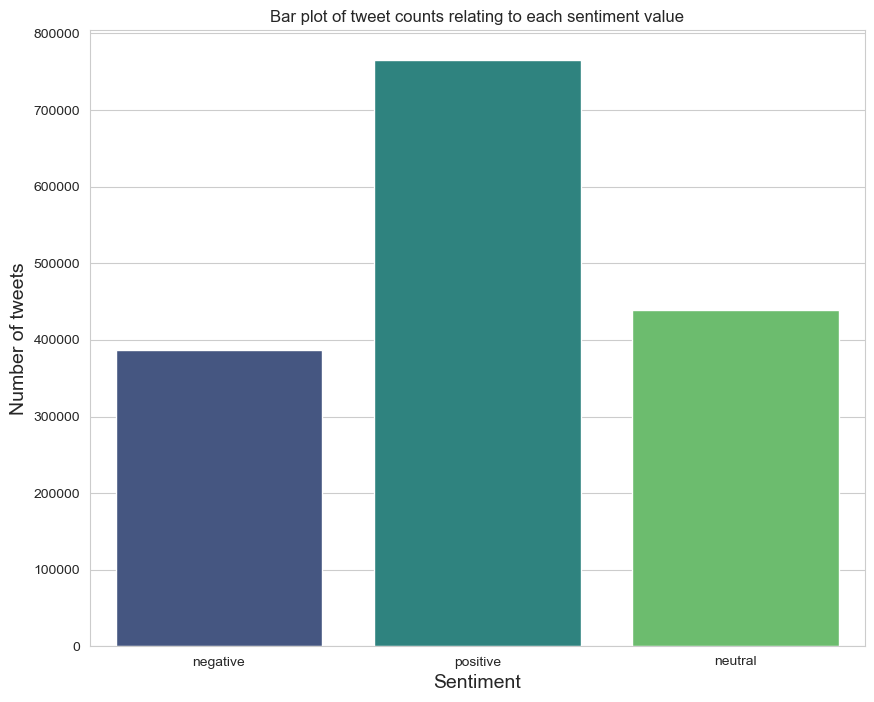

In [25]:
plt.figure(figsize=(10,8))
sns.set_style('whitegrid')
sns.countplot(x='sentiment',data=tweets_df, palette='viridis')
plt.title('Bar plot of tweet counts relating to each sentiment value')
plt.ylabel('Number of tweets', fontsize=14)
plt.xlabel('Sentiment', fontsize=14)
plt.show()

In [32]:
num_pos = tweets_df.groupby('sentiment')['text'].count()['positive']
num_neg = tweets_df.groupby('sentiment')['text'].count()['negative']
num_neu = tweets_df.groupby('sentiment')['text'].count()['neutral']
total = tweets_df['text'].count()

In [33]:
print(f'percentage positive: {(num_pos/total)*100}')
print(f'percentage negative: {(num_neg/total)*100}')
print(f'percentage neutral: {(num_neu/total)*100}')

percentage positive: 48.100563010157295
percentage negative: 24.326699142546335
percentage neutral: 27.57273784729637


- As observed from the above bar plot, the dominant sentiment in the tweets dataset is positive, with 48.1% of all tweets being determined as positive from the VADER sentiment analyzer.

#### analysing the most frequent words in the tweets

In [34]:
#concatenating all tweets together to form one document
all_text = ' '.join(tweets_df['text'])

In [35]:
words = all_text.split()

In [36]:
fd = nltk.FreqDist(words)

In [37]:
top_words = fd.most_common(100)

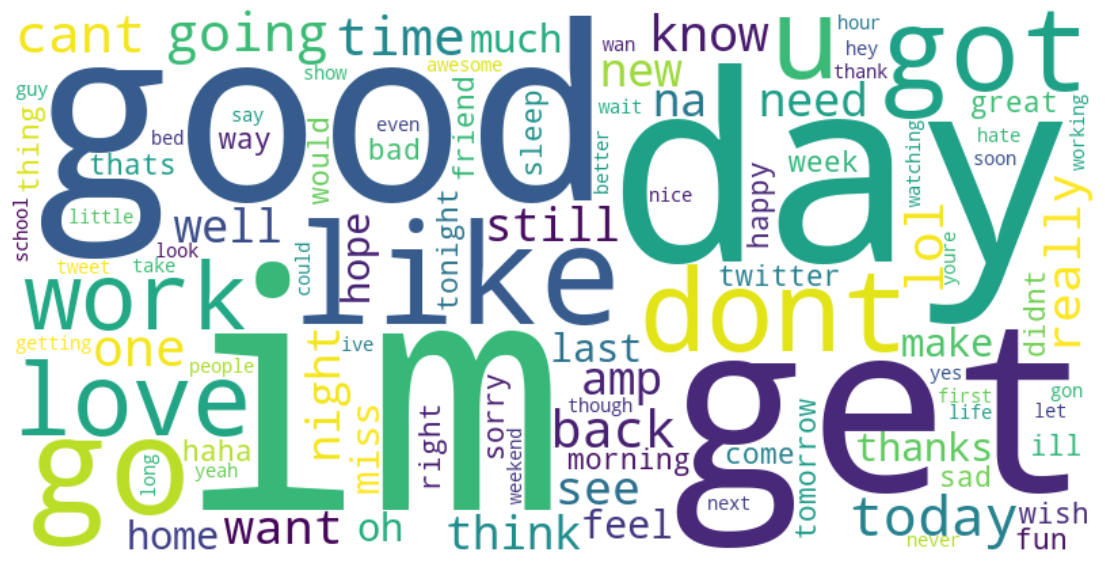

In [38]:
wc = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(top_words))

# Plot the word cloud
plt.figure(figsize=(14, 8))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

### Looking at the most common words in the tweets classified as negative:

In [39]:
tweets_df[tweets_df['sentiment']=='negative']['text']

0          awww thats bummer shoulda got david carr third...
1          upset cant update facebook texting might cry r...
3                            whole body feel itchy like fire
4                                   behaving im mad cant see
12           couldnt bear watch thought ua loss embarrassing
                                 ...                        
1592104                                   wasnt funny doggie
1592130                        omg office space wan na steal
1592131    ahaha nooo away everyone else see kara shed di...
1592139    figured see tweet facebook status update set g...
1592142    ur lead singer band beware falling prey lsd qu...
Name: text, Length: 387319, dtype: object

In [40]:
#concatenating all tweets together to form one document
neg_text = ' '.join(tweets_df[tweets_df['sentiment']=='negative']['text'])

In [41]:
neg_words = neg_text.split()

In [42]:
neg_fd = nltk.FreqDist(neg_words)

In [43]:
top_neg_words = neg_fd.most_common(100)

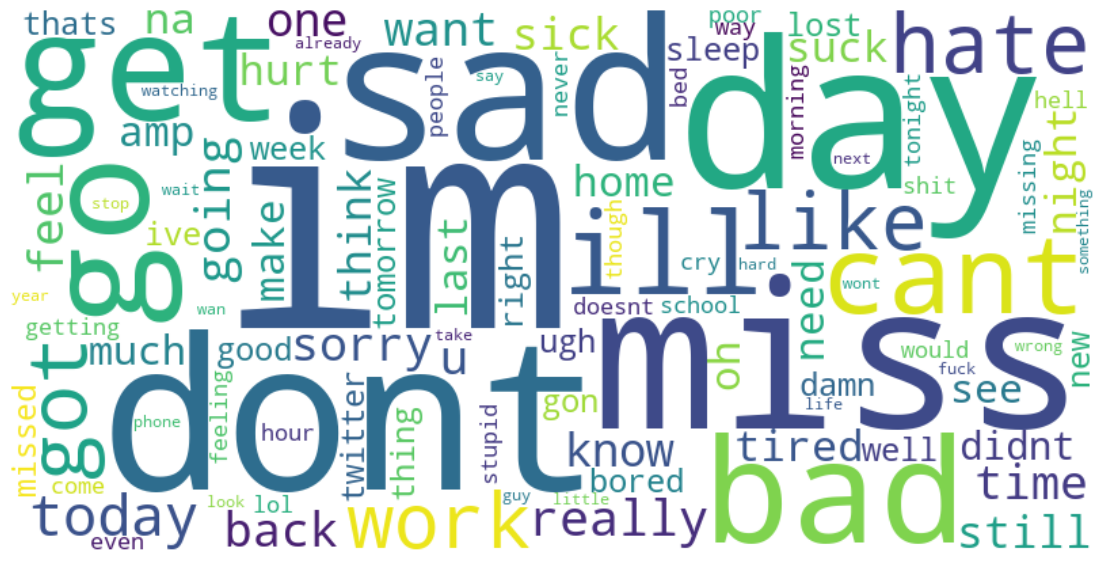

In [44]:
wc = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(top_neg_words))

# Plot the word cloud
plt.figure(figsize=(14, 8))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

In [45]:
##====================================================================================================##

## Section 3: Preparing data for Time Series Models

In [46]:
tweets_df.head()

,datetime,text,date,compound,pos_score,neg_score,neu_score,sentiment
0,2009-04-07 06:00:00,awww thats bummer shoulda got david carr third...,2009-04-07,-0.3818,0.000,0.245,0.755,negative
1,2009-04-07 06:00:00,upset cant update facebook texting might cry r...,2009-04-07,-0.7269,0.000,0.441,0.559,negative
2,2009-04-07 06:00:00,dived many time ball managed save rest go bound,2009-04-07,0.4939,0.286,0.000,0.714,positive
3,2009-04-07 06:00:00,whole body feel itchy like fire,2009-04-07,-0.2500,0.250,0.450,0.300,negative
4,2009-04-07 06:00:00,behaving im mad cant see,2009-04-07,-0.4939,0.000,0.444,0.556,negative


In [47]:
#creating time series dataframe (tweet_df_ts) and dropping columns that arent required for forecasting
tweets_df_ts = tweets_df.drop(columns=['date','text','sentiment'])

In [48]:
tweets_df_ts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1592156 entries, 0 to 1592155
Data columns (total 5 columns):
 #   Column     Non-Null Count    Dtype         
---  ------     --------------    -----         
 0   datetime   1592156 non-null  datetime64[ns]
 1   compound   1592156 non-null  float64       
 2   pos_score  1592156 non-null  float64       
 3   neg_score  1592156 non-null  float64       
 4   neu_score  1592156 non-null  float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 60.7 MB


#### In order to transform the dataset into a time series, the average hourly sentiment scores are determined and the dataset is grouped into hourly intervals:

In [49]:
#getting the mean sentiment scores per hour
tweets_df_ts = tweets_df_ts.groupby('datetime').mean()

In [50]:
tweets_df_ts.head()

,compound,pos_score,neg_score,neu_score
datetime,,,,
2009-04-07 06:00:00,0.140605,0.236113,0.122964,0.640918
2009-04-07 07:00:00,0.160121,0.242813,0.123006,0.634184
2009-04-07 08:00:00,0.176024,0.250339,0.106104,0.643562
2009-04-07 09:00:00,0.170781,0.241128,0.109694,0.648670
2009-04-07 10:00:00,0.184932,0.252483,0.100900,0.646616


In [51]:
tweets_df_ts = tweets_df_ts.reset_index()

In [52]:
tweets_df_ts['datetime'] = pd.to_datetime(tweets_df_ts['datetime'], format="%Y-%m-%d %H:%M:%S")

In [53]:
tweets_df_ts = tweets_df_ts.set_index('datetime')

In [54]:
#num_tweets = pd.DataFrame(tweets_df.groupby('datetime').size()).rename(columns={0:'num_tweets'})
#tweets_df_ts = pd.merge(tweets_df_ts, num_tweets, left_index=True, right_index=True,how='left')

In [13]:
tweets_df_ts

,compound,pos_score,neg_score,neu_score
datetime,,,,
2009-04-07 06:00:00,0.140605,0.236113,0.122964,0.640918
2009-04-07 07:00:00,0.160121,0.242813,0.123006,0.634184
2009-04-07 08:00:00,0.176024,0.250339,0.106104,0.643562
2009-04-07 09:00:00,0.170781,0.241128,0.109694,0.648670
2009-04-07 10:00:00,0.184932,0.252483,0.100900,0.646616
...,...,...,...,...
2009-06-25 14:00:00,-0.001591,0.158723,0.180995,0.660282
2009-06-25 15:00:00,0.001570,0.162225,0.175072,0.662705
2009-06-25 16:00:00,-0.023923,0.154929,0.191888,0.653182


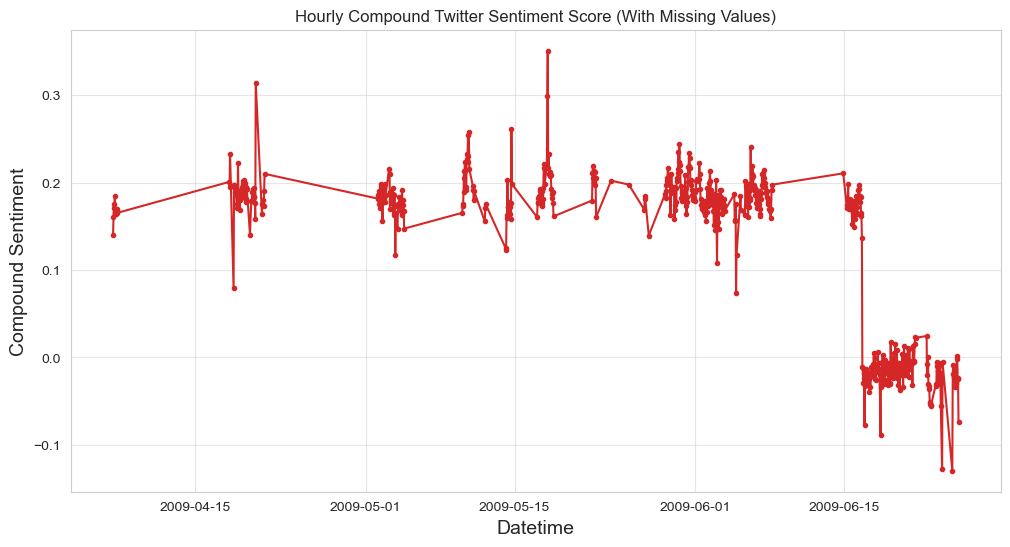

In [33]:
#plotting the compound sentiment after grouping
plt.figure(figsize=(12,6), dpi=100)
plt.plot(tweets_df_ts.index, tweets_df_ts.compound, color='tab:red', marker='.')
plt.title('Hourly Compound Twitter Sentiment Score (With Missing Values)')
plt.xlabel('Datetime',fontsize=14)
plt.ylabel('Compound Sentiment',fontsize=14)
plt.grid(alpha=0.5)

plt.show()

- As observed from the above plot, there are a lot of dates and hours without any tweets in the dataset. Therefore there are large gaps in the data without any sentiment scores. To enable time series forecasting to be perforomed on the dataset, these values must be imputed. Given the sequential nature of the dataset forward filling is an appropriate method of imputation that can be applied. 

In [34]:
#using simple forward fill due to sequential nature of the data
tweets_df_ts.resample('H').ffill()

,compound,pos_score,neg_score,neu_score
datetime,,,,
2009-04-07 06:00:00,0.140605,0.236113,0.122964,0.640918
2009-04-07 07:00:00,0.160121,0.242813,0.123006,0.634184
2009-04-07 08:00:00,0.176024,0.250339,0.106104,0.643562
2009-04-07 09:00:00,0.170781,0.241128,0.109694,0.648670
2009-04-07 10:00:00,0.184932,0.252483,0.100900,0.646616
...,...,...,...,...
2009-06-25 14:00:00,-0.001591,0.158723,0.180995,0.660282
2009-06-25 15:00:00,0.001570,0.162225,0.175072,0.662705
2009-06-25 16:00:00,-0.023923,0.154929,0.191888,0.653182


In [35]:
#redefining the dataframe
tweets_df_ts = tweets_df_ts.resample('H').ffill()

In [36]:
tweets_df_ts.head(15)

,compound,pos_score,neg_score,neu_score
datetime,,,,
2009-04-07 06:00:00,0.140605,0.236113,0.122964,0.640918
2009-04-07 07:00:00,0.160121,0.242813,0.123006,0.634184
2009-04-07 08:00:00,0.176024,0.250339,0.106104,0.643562
2009-04-07 09:00:00,0.170781,0.241128,0.109694,0.648670
2009-04-07 10:00:00,0.184932,0.252483,0.100900,0.646616
2009-04-07 11:00:00,0.165636,0.252674,0.114834,0.631986
2009-04-07 12:00:00,0.169824,0.246431,0.111708,0.641861
2009-04-07 13:00:00,0.164536,0.241759,0.112109,0.646131
2009-04-07 14:00:00,0.169543,0.243356,0.110639,0.645493


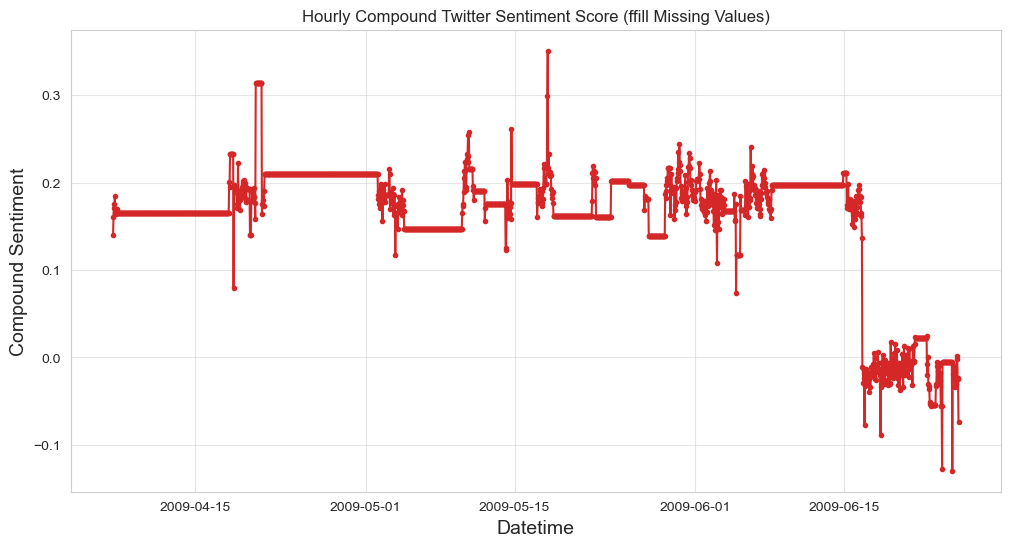

In [38]:
#plotting the compound sentiment after imputing using forward fill
plt.figure(figsize=(12,6), dpi=100)
plt.plot(tweets_df_ts.index, tweets_df_ts.compound, color='tab:red', marker='.')
plt.title('Hourly Compound Twitter Sentiment Score (ffill Missing Values)')
plt.xlabel('Datetime',fontsize=14)
plt.ylabel('Compound Sentiment',fontsize=14)
plt.grid(alpha=.5)
plt.show()

#### Imputing the missing values:

In [57]:
#using simple forward fill due to sequential nature of the data
tweets_df_ts.resample('H').ffill()

,compound,pos_score,neg_score,neu_score
datetime,,,,
2009-04-07 06:00:00,0.140605,0.236113,0.122964,0.640918
2009-04-07 07:00:00,0.160121,0.242813,0.123006,0.634184
2009-04-07 08:00:00,0.176024,0.250339,0.106104,0.643562
2009-04-07 09:00:00,0.170781,0.241128,0.109694,0.648670
2009-04-07 10:00:00,0.184932,0.252483,0.100900,0.646616
...,...,...,...,...
2009-06-25 14:00:00,-0.001591,0.158723,0.180995,0.660282
2009-06-25 15:00:00,0.001570,0.162225,0.175072,0.662705
2009-06-25 16:00:00,-0.023923,0.154929,0.191888,0.653182


In [58]:
#redefining the dataframe
tweets_df_ts = tweets_df_ts.resample('H').ffill()

In [59]:
tweets_df_ts.head(15)

,compound,pos_score,neg_score,neu_score
datetime,,,,
2009-04-07 06:00:00,0.140605,0.236113,0.122964,0.640918
2009-04-07 07:00:00,0.160121,0.242813,0.123006,0.634184
2009-04-07 08:00:00,0.176024,0.250339,0.106104,0.643562
2009-04-07 09:00:00,0.170781,0.241128,0.109694,0.648670
2009-04-07 10:00:00,0.184932,0.252483,0.100900,0.646616
2009-04-07 11:00:00,0.165636,0.252674,0.114834,0.631986
2009-04-07 12:00:00,0.169824,0.246431,0.111708,0.641861
2009-04-07 13:00:00,0.164536,0.241759,0.112109,0.646131
2009-04-07 14:00:00,0.169543,0.243356,0.110639,0.645493


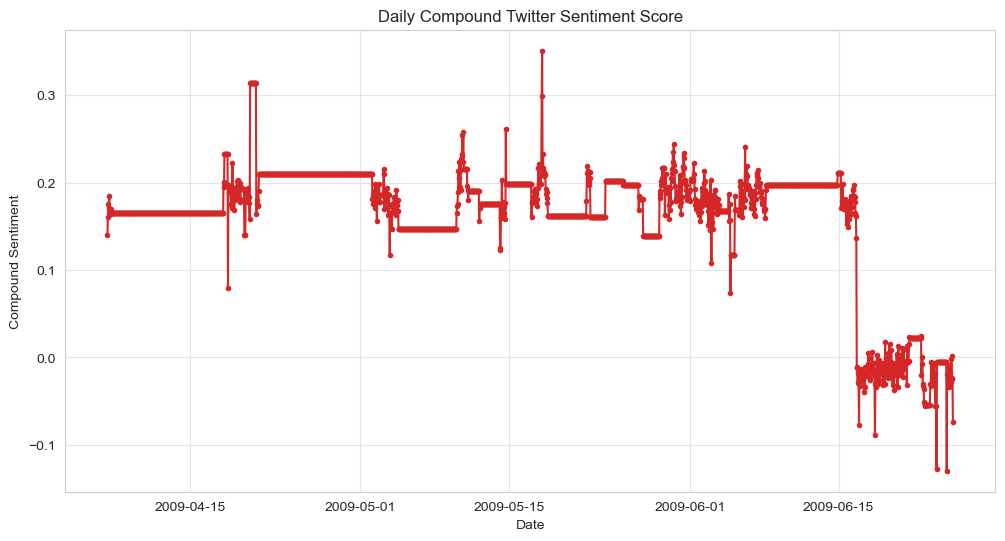

In [60]:
#plotting the compound sentiment after imputing using forward fill
plt.figure(figsize=(12,6), dpi=100)
plt.plot(tweets_df_ts.index, tweets_df_ts.compound, color='tab:red', marker='.')
plt.title('Daily Compound Twitter Sentiment Score')
plt.xlabel('Date')
plt.ylabel('Compound Sentiment')
plt.grid(alpha=.5)
plt.show()

In [61]:
#filtering dataset
#model_df_ts = tweets_df_ts[tweets_df_ts.index > pd.to_datetime(' 2009-04-18 03:00:00')]

In [63]:
##=========================================================================================================##

# Section 4: Time series forecasting

## 4.1 method 1:  LSTM 

The neural network to be implemented as part of this project is a type of Recurrent Neural Network (RNN) called a Long Short-Term Memory (LSTM) network. This model was chosen as unlike traditional neural networks LSTM incorporates feedback connections making it highly effective in understanding and predicting patterns in sequential data (time series).<br>

### 4.1.1 Preparing the training and testing data for the LSTM model:

In [163]:
#selecting only the compound sentiment score from the dataframe
data = tweets_df_ts.filter(['compound'])

In [164]:
data

,compound
datetime,
2009-04-07 06:00:00,0.140605
2009-04-07 07:00:00,0.160121
2009-04-07 08:00:00,0.176024
2009-04-07 09:00:00,0.170781
2009-04-07 10:00:00,0.184932
...,...
2009-06-25 14:00:00,-0.001591
2009-06-25 15:00:00,0.001570
2009-06-25 16:00:00,-0.023923


In [165]:
#selecting out the values of compound score to create an array of values
data = data.values

In [166]:
#determining the length of the training data as 90% of the values in the dataset
training_len = math.ceil( len(data) * 0.85)

In [167]:
#splitting the data into training data using slicing
#since the data is timeseries, it cannot be split randomly using train_test_split
training_data = data[0:training_len , :]

- **n_steps** specifies how many previous observations should be considered by the network when making a prediction about the current observation.<br>

In [168]:
#using 96 steps corresponding to the previous 96 hours (i.e 4 days) to predict next hour
n_steps = 96
testing_data = data[training_len - n_steps: , :]

In [169]:
#defining empty arrays for appending independent and dependent features
x_train =[]
y_train =[]

x_test = []
y_test = data[training_len:]

# iterating through the specified number of steps to create
# multiple samples where each sample has a specified number of time steps and the output is a single time step.
for i in range(n_steps, training_len):
    x_train.append(training_data[i - n_steps: i, 0])
    y_train.append(training_data[i, 0])

for i in range(n_steps, len(testing_data)):
    x_test.append(testing_data[i - n_steps: i, 0])

In [170]:
#the training and testing data needs to be transformed into an array to be compatible with the LSTM
x_train = np.array(x_train)
y_train = np.array(y_train)

x_test = np.array(x_test)
y_test = np.array(y_test)

In [171]:
## looking at the shapes
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((1527, 96), (1527,), (286, 96), (286, 1))

In [172]:
# reshape input to be [samples, time steps, features], for compatibility with LSTM
x_train = np.reshape(x_train,(x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test,(x_test.shape[0], x_test.shape[1], 1))
print(x_train.shape)
print(x_test.shape)

(1527, 96, 1)
(286, 96, 1)


### 4.1.2 Building the LSTM models for varying complexity to determine optimal hyperparameters:

- The two LSTM layers are set up with 20 neurons each. This configuration was chosen as it creates a baseline model which isnt too complex. The first hidden layer specifies the shape of the input in the hyperparameter **input_shape**. x_train.shape[1] indicates the number of time steps and 1 indicates there is one feature at each time step.<br>
- **return_sequences** must always be specified if the current hidden layer is connected to another LSTM layer. specifying return_sequences = False (or leaving blank) indicates the last LSTM layer in the network.<br>
- No activation function is specified in any of the LSTM layers.This is because the default activation function is the hyperbolic tangent (*tanh*) which introduces non-linearity into the model and is commonly left as the activation function in LSTM architectures.<br>
- A *Dense* layer with one neuron (representing one output value) serves as an output layer of the model. The default *linear* activation function is used for this layer due to the nature of the data being predicted.


In [173]:
model_lstm_1 = Sequential()
model_lstm_1.add(LSTM(20, return_sequences = True, input_shape = (x_train.shape[1], 1)))
model_lstm_1.add(LSTM(20, return_sequences = False ))
model_lstm_1.add(Dense(1))

mean squared error (mse) is used for the loss function as it is appropriate for regression problems, while *adam* is used as the optimizer:

In [174]:
model_lstm_1.compile(loss='mse', optimizer='adam')

- **epoch** refers to an iteration of the LSTM. For this model 50 iterations is deemed appropriate to manage complexity
- **batch_size** refers to the number of samples or data points used in each iteration during the training process. Having this too large may result in underfitting, causing the model not to generalize well. However, having this value too small may be very computational expensive. 40 is chosen as an appropriate value.

In [175]:
#fitting the lstm model with 50 epochs and a batch size of 40
lstm_history = model_lstm_1.fit(x_train, y_train, epochs = 50, batch_size = 40)

Epoch 1/50
39/39 [==============================] - 3s 26ms/step - loss: 0.0042
Epoch 2/50
39/39 [==============================] - 1s 25ms/step - loss: 5.1639e-04
Epoch 3/50
39/39 [==============================] - 1s 24ms/step - loss: 4.4824e-04
Epoch 4/50
39/39 [==============================] - 1s 24ms/step - loss: 4.3387e-04
Epoch 5/50
39/39 [==============================] - 1s 25ms/step - loss: 4.1624e-04
Epoch 6/50
39/39 [==============================] - 1s 25ms/step - loss: 4.0760e-04
Epoch 7/50
39/39 [==============================] - 1s 25ms/step - loss: 3.9196e-04
Epoch 8/50
39/39 [==============================] - 1s 26ms/step - loss: 3.9110e-04
Epoch 9/50
39/39 [==============================] - 1s 27ms/step - loss: 3.8424e-04
Epoch 10/50
39/39 [==============================] - 1s 27ms/step - loss: 3.7341e-04
Epoch 11/50
39/39 [==============================] - 1s 27ms/step - loss: 3.6074e-04
Epoch 12/50
39/39 [==============================] - 1s 27ms/step - loss: 3.48

In [176]:
#making predictions from the training neural network
y_preds_train_lstm_1 = model_lstm_1.predict(x_train)
y_preds_test_lstm_1 = model_lstm_1.predict(x_test) 

9/9 [==============================] - 0s 9ms/step


In [177]:
## accuracy metrics for regression model: 
r_squared_test_lstm_1 = r2_score(y_test,y_preds_test_lstm_1)
r_squared_train_lstm_1 = r2_score(y_train,y_preds_train_lstm_1)

mse_test_lstm_1 = mse(y_test, y_preds_test_lstm_1)

print(f'1) the mean squared error for the test set is: {mse_test_lstm_1[0]}')
print(f'2) the r^2 score for the test set is: {r_squared_test_lstm_1}')
print(f'3) the r^2 score for the training set is: {r_squared_train_lstm_1}')

1) the mean squared error for the test set is: 0.0008283316320847378
2) the r^2 score for the test set is: 0.893946947004339
3) the r^2 score for the training set is: 0.7548230841306167


### increasing LSTM complexity by adding more layers and neurons (units)

In [178]:
model_lstm_2 = Sequential()
model_lstm_2.add(LSTM(units= 45, return_sequences = True, input_shape = (x_train.shape[1], 1)))
model_lstm_2.add(LSTM(units= 45, return_sequences = True))
model_lstm_2.add(LSTM(units= 45))
model_lstm_2.add(Dense(1))

In [179]:
model_lstm_2.compile(loss='mse', optimizer='adam')

In [180]:
lstm_history = model_lstm_2.fit(x_train, y_train, epochs = 50, batch_size = 40)

Epoch 1/50
39/39 [==============================] - 5s 46ms/step - loss: 0.0026
Epoch 2/50
39/39 [==============================] - 2s 49ms/step - loss: 4.8894e-04
Epoch 3/50
39/39 [==============================] - 2s 53ms/step - loss: 4.6504e-04
Epoch 4/50
39/39 [==============================] - 2s 49ms/step - loss: 4.6545e-04
Epoch 5/50
39/39 [==============================] - 2s 47ms/step - loss: 4.3655e-04
Epoch 6/50
39/39 [==============================] - 2s 51ms/step - loss: 4.4994e-04
Epoch 7/50
39/39 [==============================] - 2s 63ms/step - loss: 4.1337e-04
Epoch 8/50
39/39 [==============================] - 2s 60ms/step - loss: 4.1776e-04
Epoch 9/50
39/39 [==============================] - 2s 58ms/step - loss: 3.8930e-04
Epoch 10/50
39/39 [==============================] - 2s 55ms/step - loss: 3.8221e-04
Epoch 11/50
39/39 [==============================] - 2s 58ms/step - loss: 3.9847e-04
Epoch 12/50
39/39 [==============================] - 3s 73ms/step - loss: 3.63

In [181]:
y_preds_train_lstm_2 = model_lstm_2.predict(x_train)
y_preds_test_lstm_2  = model_lstm_2.predict(x_test) 

9/9 [==============================] - 0s 17ms/step


In [182]:
## accuracy metrics for regression model: 
r_squared_test_lstm_2 = r2_score(y_test,y_preds_test_lstm_2)
r_squared_train_lstm_2 = r2_score(y_train,y_preds_train_lstm_2)

mse_test_lstm_2 = mse(y_test, y_preds_test_lstm_2)

print(f'1) the mean squared error for the test set is: {mse_test_lstm_2[0]}')
print(f'2) the r^2 score for the test set is: {r_squared_test_lstm_2}')
print(f'3) the r^2 score for the training set is: {r_squared_train_lstm_2}')

1) the mean squared error for the test set is: 0.0006574384740604495
2) the r^2 score for the test set is: 0.9158267599229064
3) the r^2 score for the training set is: 0.7322432556958491


### increasing LSTM complexity, adding dropout to reduce overfitting

Dropout regularization is a technique used to avoid overfitting when training neural networks.<br>
The dropout rate indicates how many neurons should be dropped in a specific layer of the neural network. It is common to use a dropout rate of 20%.

In [183]:
model_lstm_3 = Sequential()
model_lstm_3.add(LSTM(units= 45, return_sequences = True, input_shape = (x_train.shape[1], 1)))
model_lstm_3.add(Dropout(0.2))
model_lstm_3.add(LSTM(units= 45, return_sequences = True))
model_lstm_3.add(Dropout(0.2))
model_lstm_3.add(LSTM(units= 45))
model_lstm_3.add(Dense(1))

In [184]:
model_lstm_3.compile(loss='mse', optimizer='adam')

In [185]:
lstm_history = model_lstm_3.fit(x_train, y_train, epochs = 50, batch_size = 40)

Epoch 1/50
39/39 [==============================] - 6s 70ms/step - loss: 0.0032
Epoch 2/50
39/39 [==============================] - 3s 69ms/step - loss: 5.3659e-04
Epoch 3/50
39/39 [==============================] - 2s 58ms/step - loss: 5.1172e-04
Epoch 4/50
39/39 [==============================] - 2s 56ms/step - loss: 4.8338e-04
Epoch 5/50
39/39 [==============================] - 2s 56ms/step - loss: 4.6921e-04
Epoch 6/50
39/39 [==============================] - 2s 58ms/step - loss: 4.5606e-04
Epoch 7/50
39/39 [==============================] - 2s 56ms/step - loss: 4.4422e-04
Epoch 8/50
39/39 [==============================] - 2s 61ms/step - loss: 4.4246e-04
Epoch 9/50
39/39 [==============================] - 3s 64ms/step - loss: 4.1395e-04
Epoch 10/50
39/39 [==============================] - 2s 58ms/step - loss: 3.9992e-04
Epoch 11/50
39/39 [==============================] - 2s 56ms/step - loss: 4.3252e-04
Epoch 12/50
39/39 [==============================] - 2s 56ms/step - loss: 4.05

In [186]:
y_preds_train_lstm_3 = model_lstm_3.predict(x_train)
y_preds_test_lstm_3  = model_lstm_3.predict(x_test) 

9/9 [==============================] - 0s 16ms/step


In [187]:
## accuracy metrics for regression model: 
r_squared_test_lstm_3 = r2_score(y_test, y_preds_test_lstm_3)
r_squared_train_lstm_3 = r2_score(y_train, y_preds_train_lstm_3)

mse_test_lstm_3 = mse(y_test, y_preds_test_lstm_3)

print(f'1) the mean squared error for the test set is: {mse_test_lstm_3[0]}')
print(f'2) the r^2 score for the test set is: {r_squared_test_lstm_3}')
print(f'3) the r^2 score for the training set is: {r_squared_train_lstm_3}')

1) the mean squared error for the test set is: 0.0005890111354208878
2) the r^2 score for the test set is: 0.9245876569960139
3) the r^2 score for the training set is: 0.7416541712569799


### 4.1.3 Model comparison

In [190]:
models = np.array(['LSTM_1','LSTM_2','LSTM_3'])

r_squared_test = np.array([r_squared_test_lstm_1,r_squared_test_lstm_2,r_squared_test_lstm_3])
r_squared_train = np.array([r_squared_train_lstm_1,r_squared_train_lstm_2,r_squared_train_lstm_3])

mse_test = np.array([mse_test_lstm_1[0],mse_test_lstm_2[0], mse_test_lstm_3[0]])

In [189]:
#creating a dataframe from arrays
comparison_metrics = pd.DataFrame({'models':models,
                                  'r_squared_test':r_squared_test,
                                  'mse_test':mse_test})

comparison_metrics

,models,r_squared_test,mse_test
0,LSTM_1,0.893947,0.000828
1,LSTM_2,0.915827,0.000657
2,LSTM_3,0.924588,0.000589


### 4.1.4 plotting the predictions values using optimal LSTM model: LSTM_3

In [191]:
results = pd.DataFrame({'actual values':np.append(y_train,y_test),
                        'predicted values':np.append(y_preds_train_lstm_3,y_preds_test_lstm_3)})

In [192]:
results.head()

,actual values,predicted values
0,0.165467,0.164246
1,0.165467,0.164246
2,0.165467,0.164246
3,0.165467,0.164246
4,0.165467,0.164246


In [193]:
#getting the length of training data
training_len

1623

In [194]:
train = results['actual values'][:training_len]

In [195]:
test = results['actual values'][training_len:]

In [196]:
predictions = results['predicted values'][training_len:]

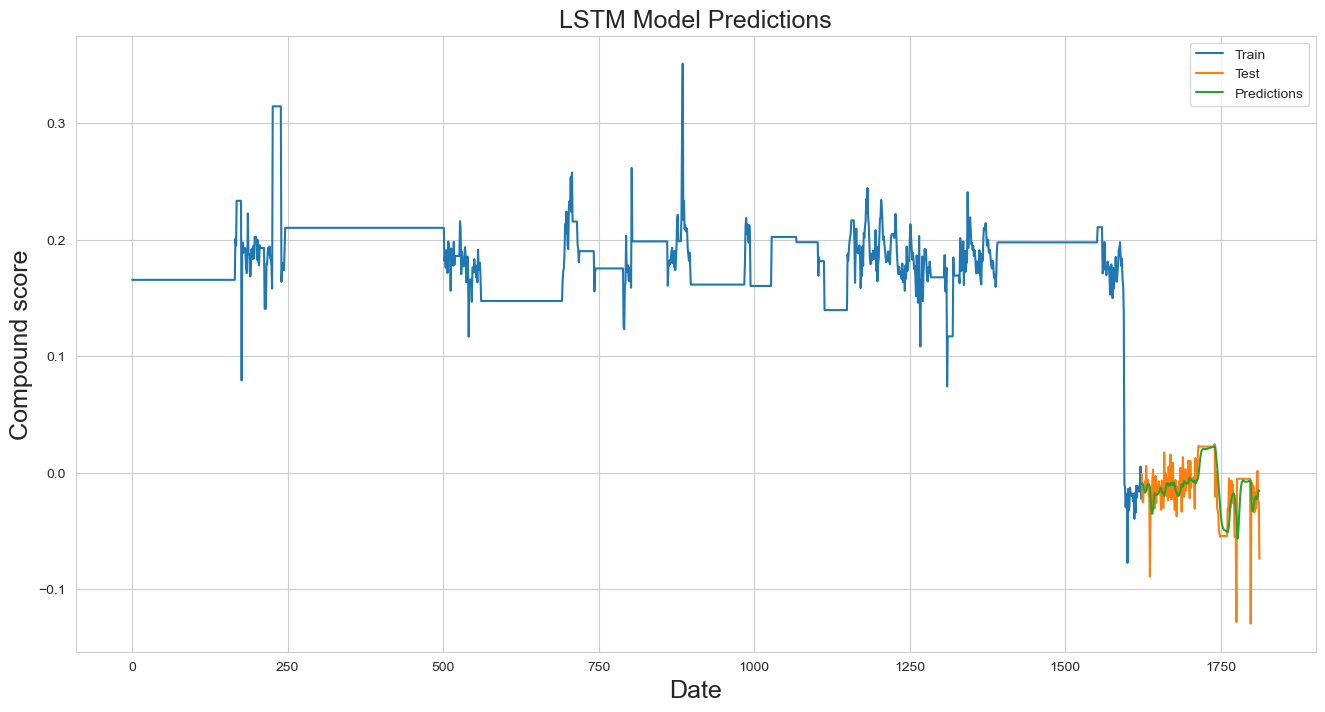

In [197]:
#plotting the predictions
plt.figure(figsize=(16,8))
plt.title('LSTM Model Predictions', fontsize=18)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Compound score', fontsize=18)
plt.plot(train)
plt.plot(test)
plt.plot(predictions)
plt.legend(['Train', 'Test', 'Predictions'], loc = 'upper right')
plt.show()

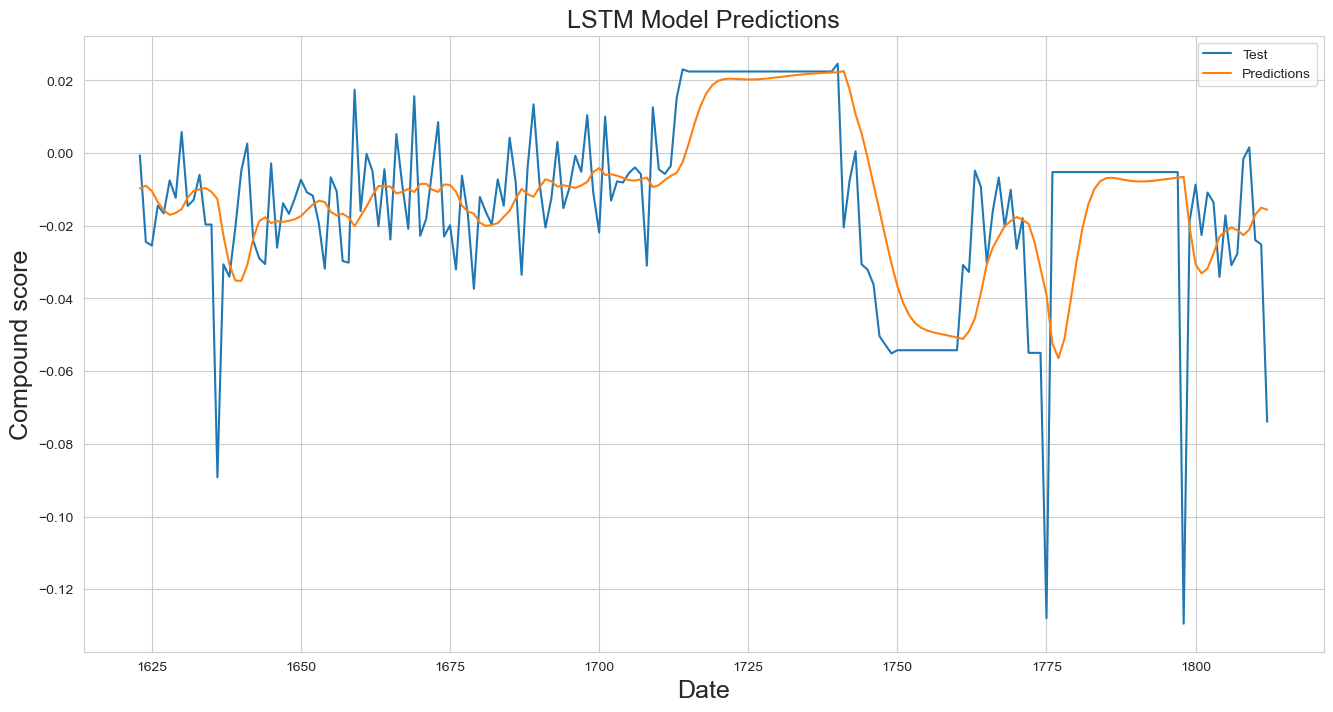

In [198]:
#plotting the predictions
plt.figure(figsize=(16,8))
plt.title('LSTM Model Predictions', fontsize=18)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Compound score', fontsize=18)
plt.plot(test)
plt.plot(predictions)
plt.legend(['Test', 'Predictions'], loc = 'upper right')
plt.show()

### 4.1.5 forecasting the sentiment using LSTM_3 model

In [199]:
tweets_df_ts.tail()

,compound,pos_score,neg_score,neu_score
datetime,,,,
2009-06-25 14:00:00,-0.001591,0.158723,0.180995,0.660282
2009-06-25 15:00:00,0.001570,0.162225,0.175072,0.662705
2009-06-25 16:00:00,-0.023923,0.154929,0.191888,0.653182
2009-06-25 17:00:00,-0.025152,0.157941,0.199161,0.642894
2009-06-25 18:00:00,-0.073933,0.163910,0.237684,0.598406


In [200]:
data

array([[ 0.14060485],
       [ 0.160121  ],
       [ 0.17602449],
       ...,
       [-0.02392295],
       [-0.02515186],
       [-0.07393288]])

- defining **lstm_forecast_function** to calculate the forecasted sentiment at specified number of hours. 
- This function will forecast a future value based on the previous n_steps features. It will then pass this forecasted value into the next iteration of the function as part of the input features. This will enable a forecast to be made up until num_hours into the future (i.e 24 hours being 1 day ahead, 74 being 3 days and 168 being 7 days).
- input_data is the entire dataset worth of compound sentiment scores
- n_steps is how many previous sentiment scores will be used to forecast the next score (96 will be used as used during model training).
- num_hours represents how far into the future the model will forecast.

In [201]:
def lstm_forecast_function(input_data, n_steps, num_hours):
    #getting the last n_steps from the dataset for making forecast of next value
    forecast_input = input_data[-n_steps:]
    #reshaping for compatability with trained model
    forecast_input = forecast_input.reshape(1, -1)
    forecast_input = list(forecast_input)
    forecast_input = forecast_input[0].tolist()
    
    #creating empty array for forecast values to be appended to
    forecast_output=[]
    i=0

    #while the iterator i is less than the number of hours to forecast, this loop will be creating forecasts
    while(i<num_hours): 
        #transforming input steps into an array and reshaping
        x_input=np.array(forecast_input)
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        
        #making predictions using the trained model (lstm_3)
        pred = model_lstm_3.predict(x_input, verbose=0)
        
        #adding the forecasted value to the input for the next forecast
        forecast_input.extend(pred[0].tolist())
        forecast_input=forecast_input[1:]
        #appending forecasted value to the output array
        forecast_output.extend(pred.tolist())
        i=i+1
        
    return np.ravel(forecast_output)

In [207]:
#making forecasts for 1, 3 and 7 days ahead
forecast_1d = lstm_forecast_function(data, 96, 24)
forecast_3d = lstm_forecast_function(data, 96, 72)
forecast_7d = lstm_forecast_function(data, 96, 168)

In [64]:
#this function will create a dataframe given the forecasted values such that they each have their corresponding datetime
#this will come in use when plotting the forecasted values against the original dataset
def create_forecast_df(forecast_data, orig_dataset):
    start_date = orig_dataset.iloc[-1].name
    
    # Calculate the number of hours to increment
    num_rows = len(forecast_data) + 1
    date_range = pd.date_range(start=start_date, periods=num_rows, freq='H')[1:]
    
    index_start = (tweets_df_ts.reset_index().iloc[-1].name) + 1
    index_values = []

    for i in range (index_start, index_start + len(forecast_data)):
        index_values.append(i)
        
    forecast_df = pd.DataFrame({'index':index_values,'datetime':date_range,'forecast_sent':forecast_data})
    forecast_df = forecast_df.set_index('index')
    return forecast_df

In [209]:
#creating forecast dataframes
forecast_1d_lstm = create_forecast_df(forecast_1d, tweets_df_ts).set_index('datetime')
forecast_3d_lstm = create_forecast_df(forecast_3d, tweets_df_ts).set_index('datetime')
forecast_7d_lstm = create_forecast_df(forecast_7d, tweets_df_ts).set_index('datetime')

In [210]:
forecast_7d_lstm.head()

,datetime,forecast_sent
index,,
1813,2009-06-25 19:00:00,-0.023032
1814,2009-06-25 20:00:00,-0.028589
1815,2009-06-25 21:00:00,-0.031353
1816,2009-06-25 22:00:00,-0.032367
1817,2009-06-25 23:00:00,-0.032564


### Plotting the forecasts:

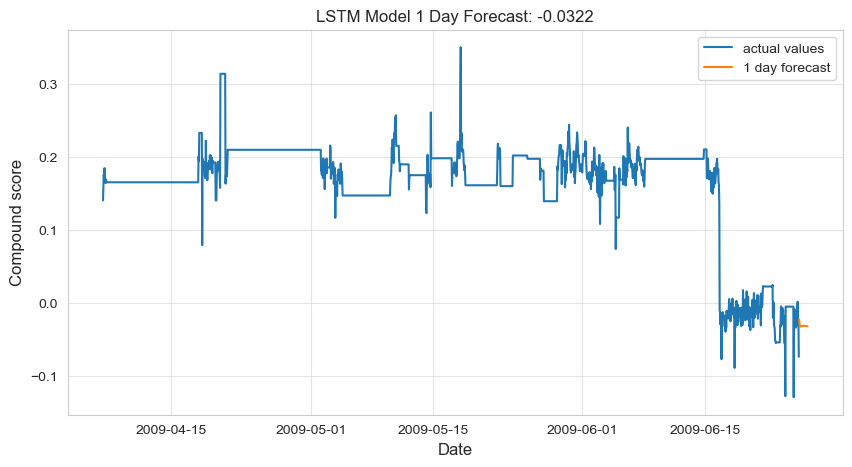

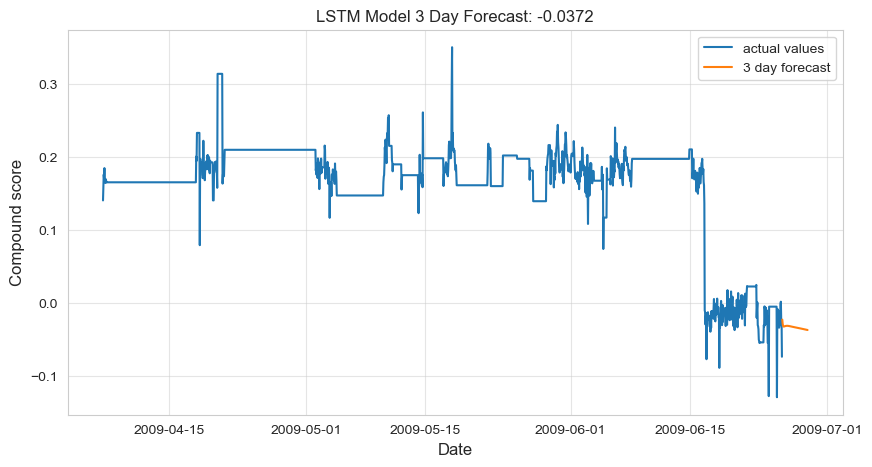

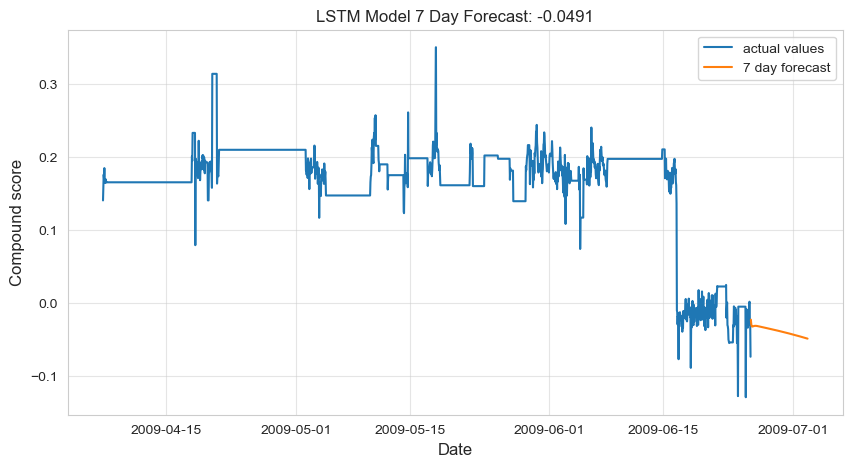

In [97]:
#plotting the predictions
plt.figure(figsize=(10,5))
plt.title(f'LSTM Model 1 Day Forecast: {round(forecast_1d_lstm.iloc[-1].forecast_sent, 4)}')
plt.xlabel('Date',fontsize=12)
plt.ylabel('Compound score', fontsize=12)
plt.plot(tweets_df_ts['compound'])
plt.plot(forecast_1d_lstm)

plt.legend(['actual values','1 day forecast'], loc = 'upper right')
plt.grid(alpha=0.5)
plt.show()


plt.figure(figsize=(10,5))
plt.title(f'LSTM Model 3 Day Forecast: {round(forecast_3d_lstm.iloc[-1].forecast_sent, 4)}')
plt.xlabel('Date',fontsize=12)
plt.ylabel('Compound score', fontsize=12)
plt.plot(tweets_df_ts['compound'])
plt.plot(forecast_3d_lstm)

plt.legend(['actual values','3 day forecast'], loc = 'upper right')
plt.grid(alpha=0.5)
plt.show()

plt.figure(figsize=(10,5))
plt.title(f'LSTM Model 7 Day Forecast: {round(forecast_7d_lstm.iloc[-1].forecast_sent, 4)}')
plt.xlabel('Date',fontsize=12)
plt.ylabel('Compound score', fontsize=12)
plt.plot(tweets_df_ts['compound'])
plt.plot(forecast_7d_lstm)

plt.legend(['actual values','7 day forecast'], loc = 'upper right')
plt.grid(alpha=0.5)
plt.show()

### Looking at the forecasts at a smaller date range:

In [148]:
#defining function to create better x_ticks for visualisations, showing every 2nd date:
def get_x_ticks(orig_dataset, forecast_dataset):
    date_ticks = pd.DataFrame(((orig_dataset['compound'].iloc[1400:]).index).append(forecast_dataset.index))
    date_ticks['datetime'] = pd.to_datetime(date_ticks['datetime'])
    return date_ticks['datetime'].dt.date.unique()[::2]

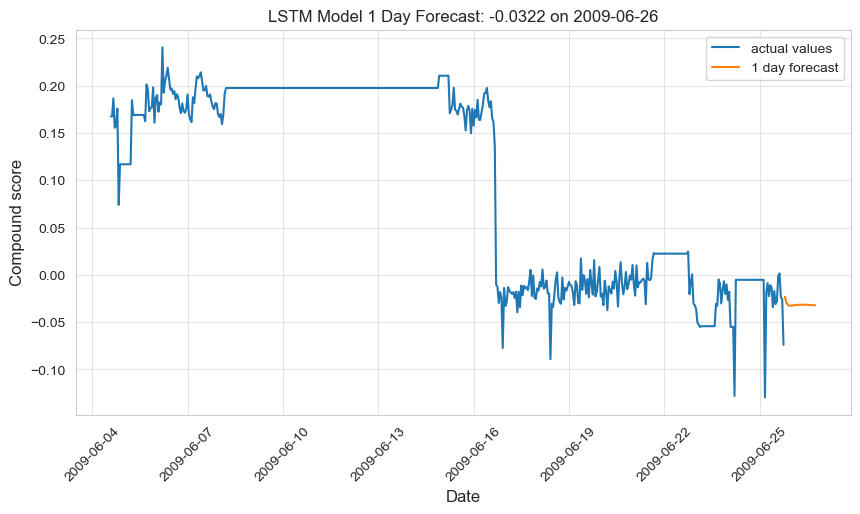

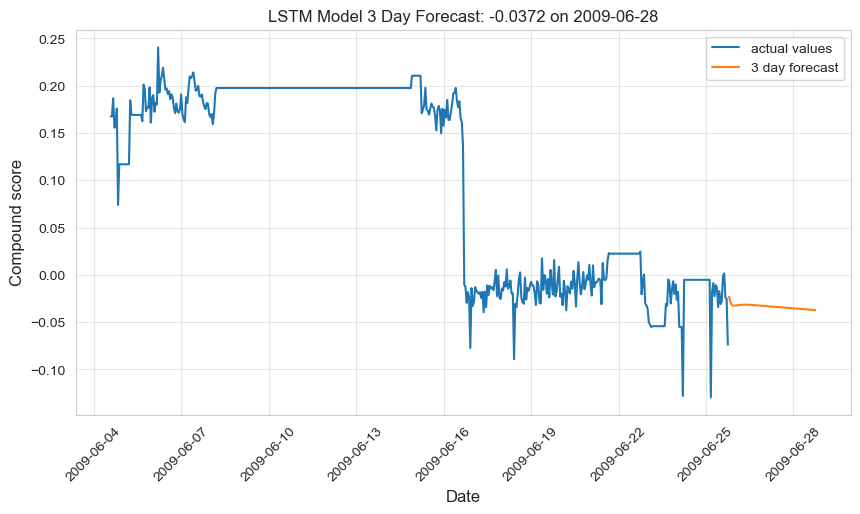

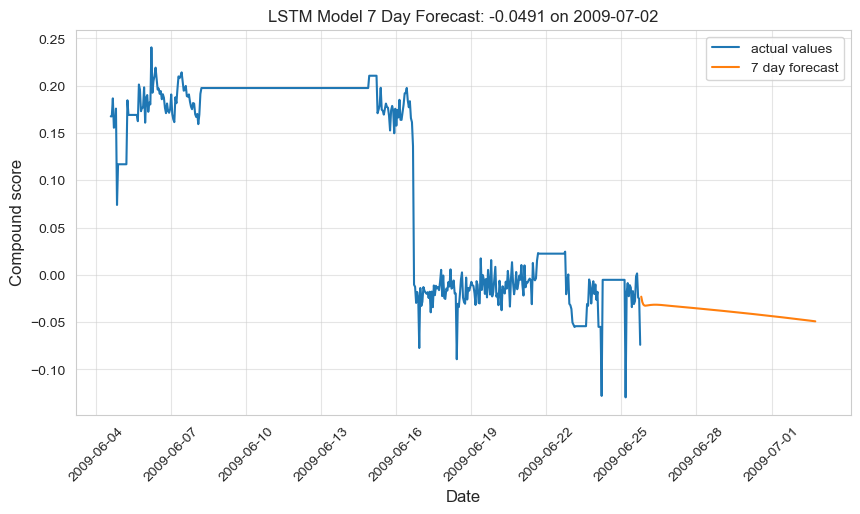

In [164]:
#plotting the predictions
plt.figure(figsize=(10,5))
_1d_date = str((forecast_1d_lstm.iloc[-1].name).date())
plt.title(f'LSTM Model 1 Day Forecast: {round(forecast_1d_lstm.iloc[-1].forecast_sent, 4)} on {_1d_date}')
plt.xlabel('Date',fontsize=12)
plt.ylabel('Compound score', fontsize=12)
plt.plot(tweets_df_ts['compound'].iloc[1400:])
plt.plot(forecast_1d_lstm)
plt.xticks(get_x_ticks(tweets_df_ts, forecast_1d_lstm), rotation=45)
plt.legend(['actual values','1 day forecast'], loc = 'upper right')
plt.grid(alpha=0.5)
plt.show()


plt.figure(figsize=(10,5))
_3d_date = str((forecast_3d_lstm.iloc[-1].name).date())
plt.title(f'LSTM Model 3 Day Forecast: {round(forecast_3d_lstm.iloc[-1].forecast_sent, 4)} on {_3d_date}')
plt.xlabel('Date',fontsize=12)
plt.ylabel('Compound score', fontsize=12)
plt.plot(tweets_df_ts['compound'].iloc[1400:])
plt.plot(forecast_3d_lstm)
plt.xticks(get_x_ticks(tweets_df_ts, forecast_3d_lstm), rotation=45)
plt.legend(['actual values','3 day forecast'], loc = 'upper right')
plt.grid(alpha=0.5)
plt.show()

plt.figure(figsize=(10,5))
_7d_date = str((forecast_7d_lstm.iloc[-1].name).date())
plt.title(f'LSTM Model 7 Day Forecast: {round(forecast_7d_lstm.iloc[-1].forecast_sent, 4)} on {_7d_date}')
plt.xlabel('Date',fontsize=12)
plt.ylabel('Compound score', fontsize=12)
plt.plot(tweets_df_ts['compound'].iloc[1400:])
plt.plot(forecast_7d_lstm)
plt.xticks(get_x_ticks(tweets_df_ts, forecast_7d_lstm), rotation=45)
plt.legend(['actual values','7 day forecast'], loc = 'upper right')
plt.grid(alpha=0.5)
plt.show()

## 4.2 method 2:  ARIMA

### 4.2.1 checking for stationarity

using the seasonal_decompose to split the time series into several components, each representing an underlying pattern category, trend (whether it is decreasing/increasing/constant), seasonality (describes the periodic signal), and residual (what remains behind the separation of seasonality and trend from the time series).

ref: https://towardsdatascience.com/time-series-decomposition-in-python-8acac385a5b2

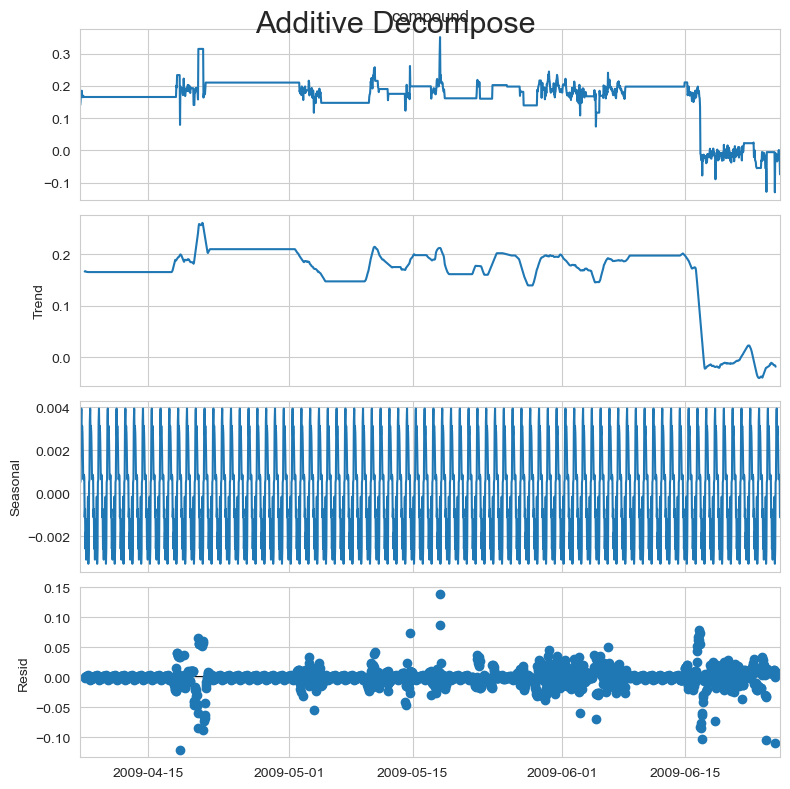

In [178]:
#extracting the compound sentiment score from the dataset
values = tweets_df_ts['compound']

result_add = seasonal_decompose(values, model='additive')

plt.rcParams.update({'figure.figsize': (8,8)})
result_add.plot().suptitle('Additive Decompose', fontsize=22)
plt.show()

### Dickey-Fuller test for stationarity

One way to test whether a time series is stationary is to perform an augmented Dickey-Fuller test, which uses the following null and alternative hypotheses:

H0: The time series is non-stationary. In other words, it has some time-dependent structure and does not have constant variance over time.

HA: The time series is stationary.

If the p-value from the test is less than some significance level (e.g. α = .05), then we can reject the null hypothesis and conclude that the time series is stationary.

In [179]:
adf_test = ADFTest(alpha=0.5)
adf_test.should_diff(values)

(0.34723899720742357, False)

From the above, we can conclude that the data is non-stationary. Hence, we would need to use the “Integrated (I)” concept, denoted by value ‘d’ in time series to make the data stationary while building the ARIMA model. This proves that the ARMA model would not be suffient for forecasting this data.

### finding the value of d (order of differencing)

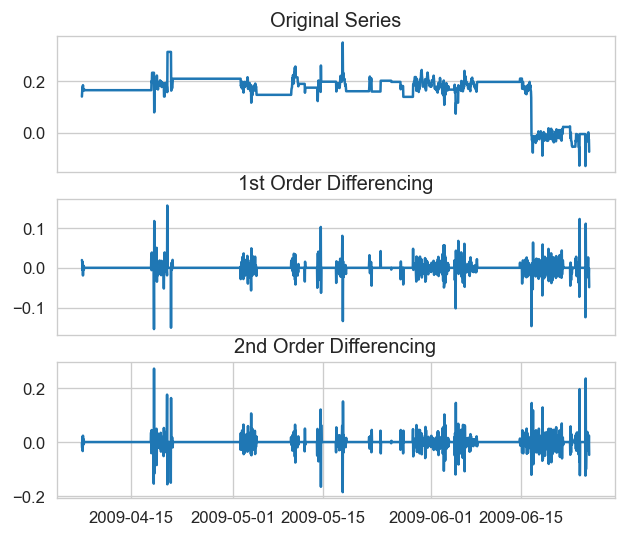

In [181]:
plt.rcParams.update({'figure.figsize':(6,5), 'figure.dpi':120})
 
# Original Series
fig, (ax1, ax2, ax3) = plt.subplots(3)
ax1.plot(values); ax1.set_title('Original Series'); ax1.axes.xaxis.set_visible(False)
# 1st Differencing
ax2.plot(values.diff()); ax2.set_title('1st Order Differencing'); ax2.axes.xaxis.set_visible(False)
# 2nd Differencing
ax3.plot(values.diff().diff()); ax3.set_title('2nd Order Differencing')
plt.show()

#### - 1st order differencing should be sufficient 

### 4.2.2 taking a look at the autocorrelation function (ACF) plot 

ref: https://towardsdatascience.com/interpreting-acf-and-pacf-plots-for-time-series-forecasting-af0d6db4061c

- estimating AR(p) and MA(q) orders solely based on autocorrelation and partial autocorrelation plots may not be reliable when the time series is not stationary. In such cases, it's essential to address the non-stationarity of the data before attempting to identify the model orders.

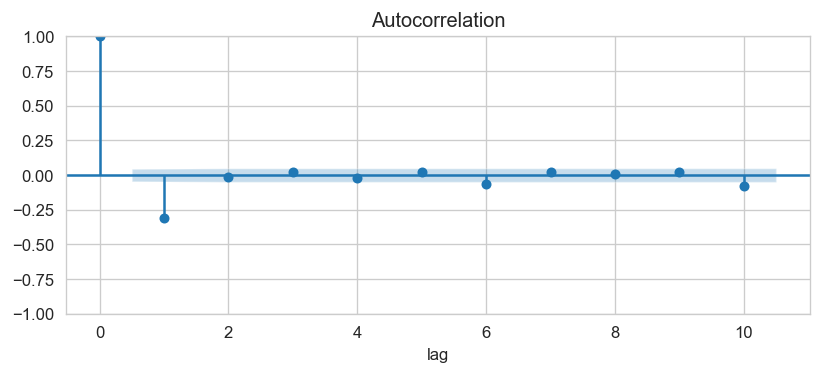

In [305]:
#plotting the autocorrelation plot which can be used for estimating q
fig, ax = plt.subplots(figsize=(8, 3))
sm.graphics.tsa.plot_acf(values.diff().dropna(),lags=10, ax=ax)
plt.xlabel('lag')
plt.show()

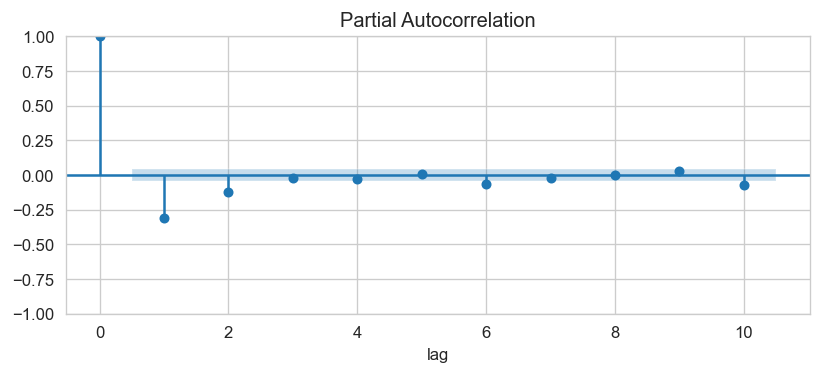

In [306]:
#plotting the partial-autocorrelation plot which can be used for estimating p
fig, ax = plt.subplots(figsize=(8, 3))
sm.graphics.tsa.plot_pacf(values.diff().dropna(), lags=10, method = "ols", ax=ax)
plt.xlabel('lag')
plt.show()

### 4.2.3 building the ARIMA model

In [278]:
#splitting the data 85% train, 15% test
train_data = values[:int(len(values)*.9)]
test_data = values[int(len(values)*0.9):]

Creating an initial ARIMA model with the following hyperparameters: 
- Autoregressive component, AR(p), which represents the number of lag observations incorporated into the model set to 2 from looking at the partial autocorrelation (PACF) graph.
- Interated component, I(d) , which represents the degree of differencing, denoting the number of times raw observations undergo differencing, is set to 1 due to non-stationarity of the dataset.
- Moving Average, MA(q), which represents the size of the moving average window is set to 1, estimating from the autocorrelation (ACF) graph.


In [291]:
#creating the initial ARIMA model
model_arima = ARIMA(train_data, order=(2, 1, 1))

In [293]:
#fitting the model
model_fit = model_arima.fit()

In [294]:
#setting indexes for making predictions with the trained model
start_index = len(train_data)
end_index = start_index + len(test_data) - 1

In [295]:
#making predictions
predictions = model_fit.predict(start_index, end_index)

In [296]:
#creating dataframe for predictions
arima_predictions = pd.DataFrame(predictions, index=test_data.index)
arima_predictions.columns=['compound_predictions']

In [297]:
arima_predictions.head()

,compound_predictions
datetime,
2009-06-17 20:00:00,0.000922
2009-06-17 21:00:00,0.000755
2009-06-17 22:00:00,0.000676
2009-06-17 23:00:00,0.000667
2009-06-18 00:00:00,0.000665


In [298]:
test = test_data.values
pred_test = predictions.values

In [299]:
#evaluating the model accuracy on the test data
arima_r2_score = r2_score(test,pred_test)
arima_r2_score

-0.2966746966445746

In [300]:
arima_r2_score = r2_score(test,pred_test)
arima_mse = mse(test,pred_test)
arima_mae = np.mean(np.abs((test - pred_test) / test)) * 100

In [301]:
print(f'1) the r^2 score for the test set is: {arima_r2_score}')
print(f'2) the mean squared error for the test set is: {arima_mse}')

1) the r^2 score for the test set is: -0.2966746966445746
2) the mean squared error for the test set is: 0.0008105694812232928


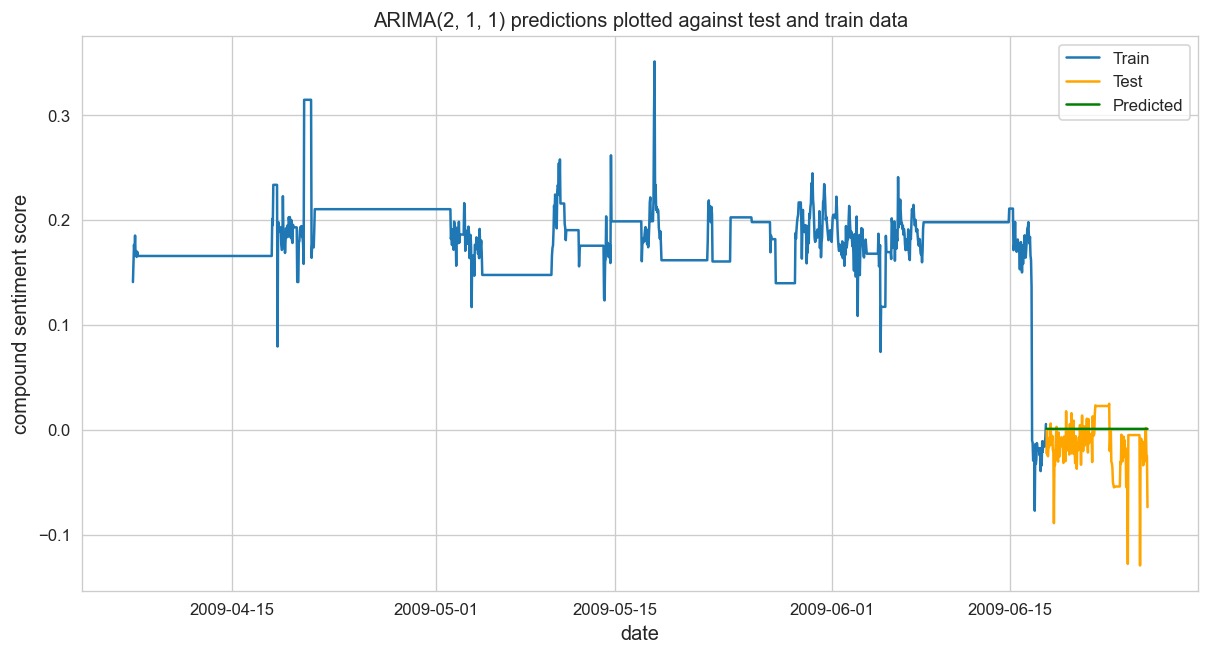

In [302]:
#plotting the predicted values against the test data and train data
plt.figure(figsize=(12,6))
plt.plot(train_data,label='Train')
plt.plot(test_data, label='Test',color='orange')
plt.plot(arima_predictions,label='Predicted',color='green')
plt.title('ARIMA(2, 1, 1) predictions plotted against test and train data',fontsize=12)
plt.xlabel('date',fontsize=12)
plt.ylabel('compound sentiment score',fontsize=12)
plt.legend()
plt.show()

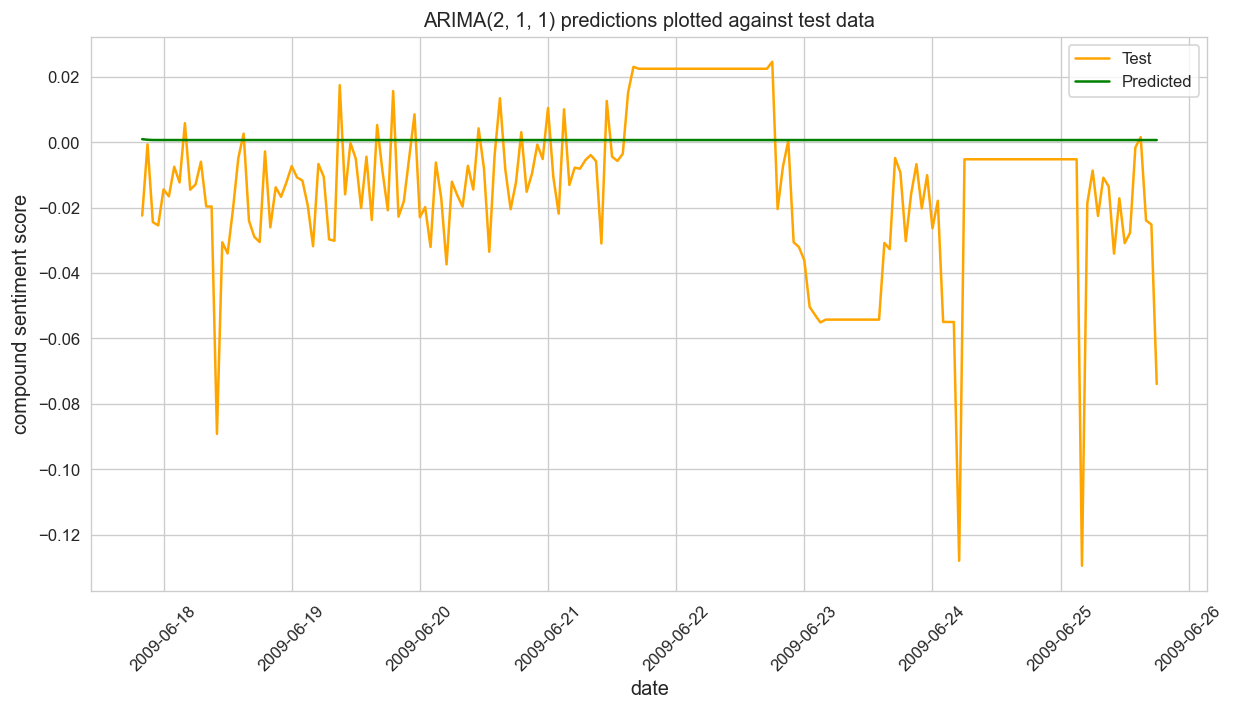

In [303]:
#plotting the predicted values against the test data
plt.figure(figsize=(12,6))
plt.plot(test_data, label='Test',color='orange')
plt.plot(arima_predictions,label='Predicted',color='green')
plt.xticks(rotation=45)
plt.title('ARIMA(2, 1, 1) predictions plotted against test data',fontsize=12)
plt.xlabel('date', fontsize=12)
plt.ylabel('compound sentiment score',fontsize=12)
plt.legend()
plt.show()

### 4.2.4 tuning ARIMA hyperparameters

In [ ]:
#arima_predictions.to_csv('arima_different_predictions.csv')

- To tune the hyperparamters, namely the autoregressive (p) and moving average (q) values, the below code will loop through different specified combinations of each parameter, appending the prediction results to a dataframe. These predictions will then be evaluated using the r2 score and root mean squared error to identify the optimal combination of these parameters. 
- The d parameter (relating to the Integrated component) of ARIMA is left as this is deemed an appropriate value to deal with the non-stationarity of the data.

In [229]:
##running through ARIMA for various values of p and q
p_vals = [1, 2, 3, 4]
q_vals = [1, 2, 3, 4]

arima_predictions = pd.DataFrame(index=test_data.index)

for q in q_vals:
    for p in p_vals:
        model_arima = ARIMA(train_data, order=(p, 1, q))
        model_fit = model_arima.fit()
        
        start_index = len(train_data)
        end_index = start_index + len(test_data) - 1
        predictions = model_fit.predict(start_index, end_index)
       
        df = pd.DataFrame(predictions, index=test_data.index)
        df.columns=['ARIMA(' +str(p)+ ', 1 ,' +str(q)+')']
        
        arima_predictions = arima_predictions.merge(df, how='left',left_index=True, right_index=True)

In [230]:
#arima_predictions.to_csv('arima_different_predictions_v2.csv')
#arima_predictions = pd.read_csv('arima_different_predictions_new.csv')
#arima_predictions = arima_predictions.set_index('datetime')

In [231]:
arima_predictions.head()

In [217]:
#creating comparison metrics dataframe
comparison_df = pd.DataFrame(columns=['Model', 'R2 score', 'RMSE'])

In [218]:
#looping through each column in the above arima_predictions dataframe to calculate the r2 score and RMSE values

comparison_df = pd.DataFrame()

for column in arima_predictions:
    test = test_data.values
    pred_test = arima_predictions[column].values
    arima_r2_score = r2_score(test,pred_test)
    arima_rmse = rmse(test,pred_test)
    comparison_df = comparison_df.append({'Model':column, 'R2 score':arima_r2_score, 'RMSE':arima_rmse},ignore_index=True)
    

In [219]:
min_index = comparison_df['MSE'].idxmin()

comparison_df.loc[min_index]

Model       ARIMA(4, 1 ,4)
R2 score         -0.286982
RMSE              0.028364
Name: 15, dtype: object

In [220]:
min_index = comparison_df['R2 score'].idxmax()

comparison_df.loc[min_index]

Model       ARIMA(4, 1 ,4)
R2 score         -0.286982
RMSE              0.028364
Name: 15, dtype: object

- Optimal model identified as **ARIMA(4, 1, 4)**

### 4.2.5 getting predictions using optimal model

In [221]:
#creating the initial ARIMA model
model_arima = ARIMA(train_data, order=(4, 1, 4))

In [223]:
#fitting the model
#model_fit = model_arima.fit()

In [224]:
start_index = len(train_data)
end_index = start_index + len(test_data) - 1

In [225]:
predictions = model_fit.predict(start_index, end_index)

In [226]:
arima_predictions = pd.DataFrame(predictions, index=test_data.index)
arima_predictions.columns=['arima_predictions']

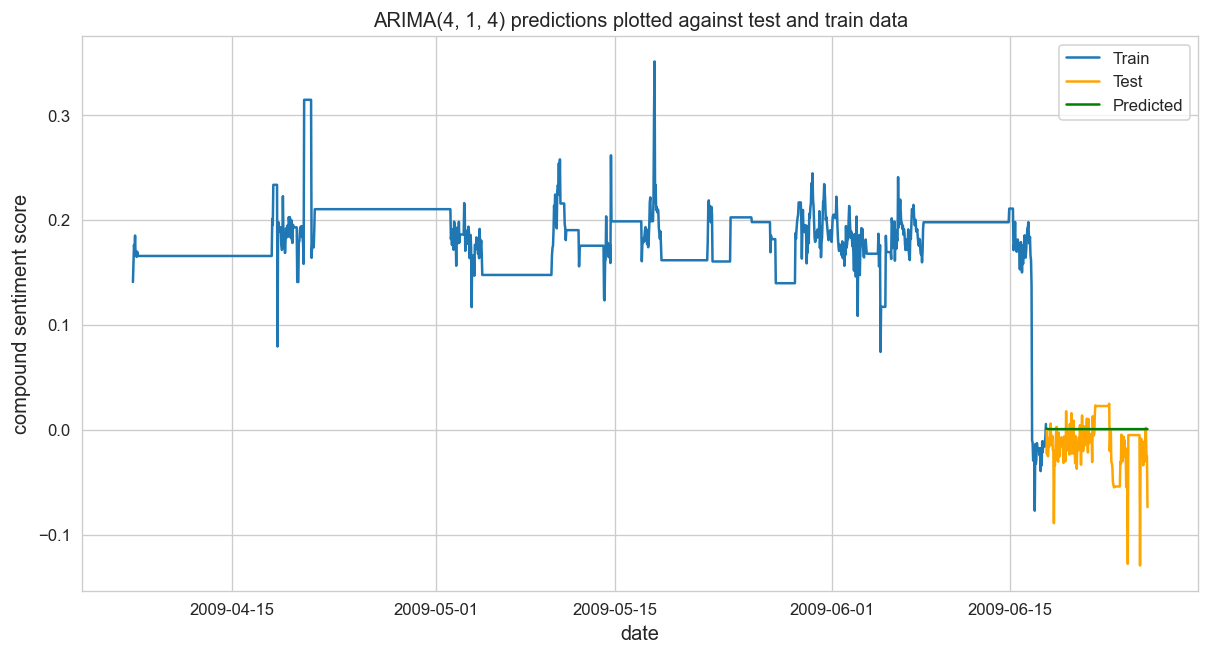

In [228]:
#plotting the predicted values against the test data and train data
plt.figure(figsize=(12,6))
plt.plot(train_data,label='Train')
plt.plot(test_data, label='Test',color='orange')
plt.plot(arima_predictions,label='Predicted',color='green')
plt.title('ARIMA(4, 1, 4) predictions plotted against test and train data',fontsize=12)
plt.xlabel('date',fontsize=12)
plt.ylabel('compound sentiment score',fontsize=12)
plt.legend()
plt.show()

#### Evaluating model accuracy

In [234]:
test = test_data.values
pred_test = predictions.values

In [235]:
#evaluating the model accuracy on the test data
arima_r2_score = r2_score(test,pred_test)
arima_r2_score

-0.28698230317061313

In [236]:
arima_r2_score = r2_score(test,pred_test)
arima_mse = mse(test,pred_test)

In [350]:
print(f'1) the r^2 score for the test set is: {arima_r2_score}')
print(f'2) the mean squared error for the test set is: {arima_mse}')

1) the r^2 score for the test set is: -0.2966746966445746
2) the mean squared error for the test set is: 0.0008105694812232928


### 4.2.6 forecasting using ARIMA model

In [240]:
#setting the number of steps at 24 hours (1 day), 72 hours (3 days) and 168 hours (7 days)
forecast_1d_arima = model_fit.forecast(steps = 24)
forecast_3d_arima = model_fit.forecast(steps = 72)
forecast_7d_arima = model_fit.forecast(steps = 168)

In [241]:
#using the create_forecast_df function defined earlier to create prediction dataframes
forecast_1d_arima = create_forecast_df(forecast_1d_arima, tweets_df_ts).set_index('datetime')
forecast_3d_arima = create_forecast_df(forecast_3d_arima, tweets_df_ts).set_index('datetime')
forecast_7d_arima = create_forecast_df(forecast_7d_arima, tweets_df_ts).set_index('datetime')

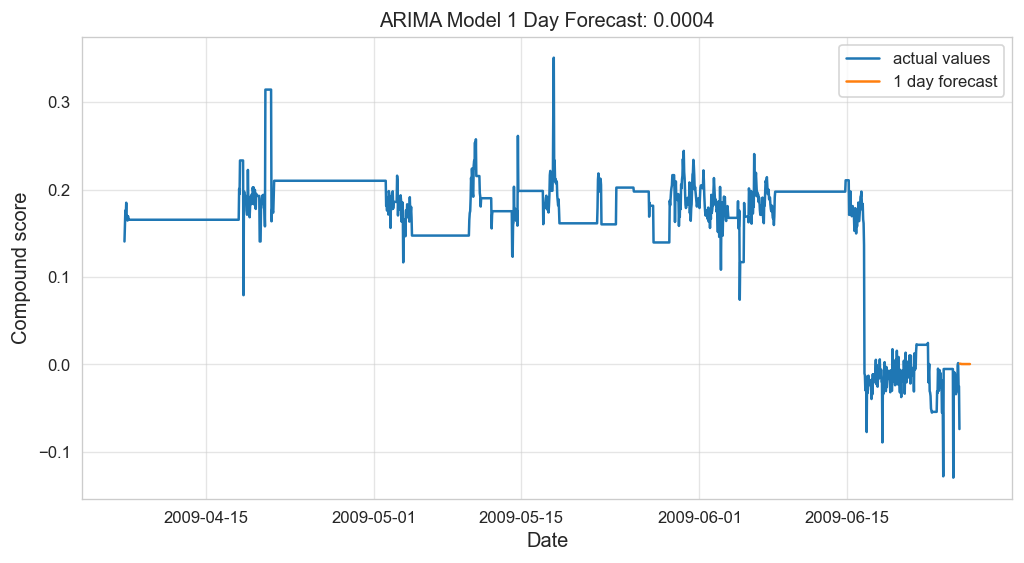

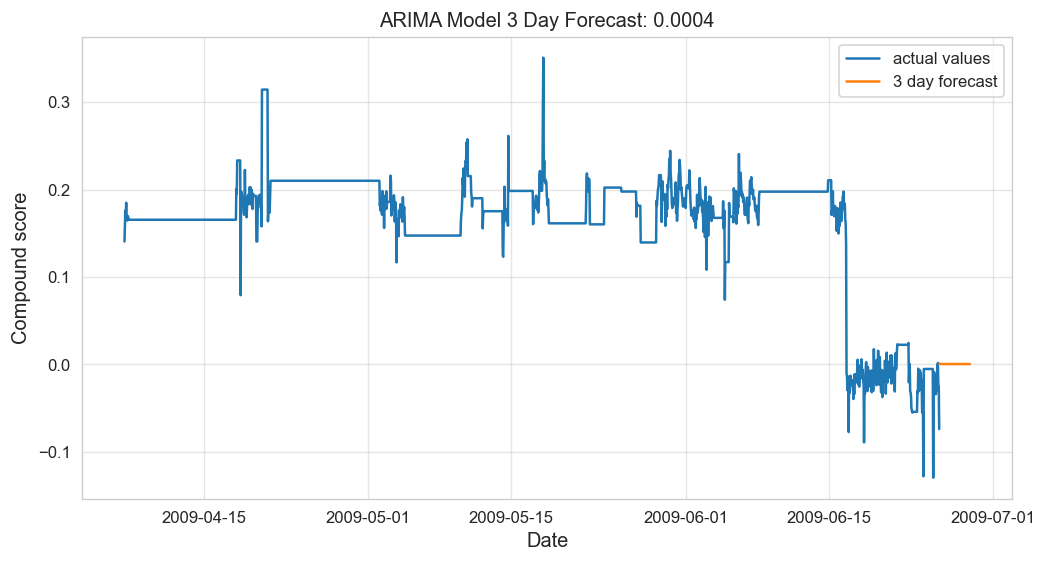

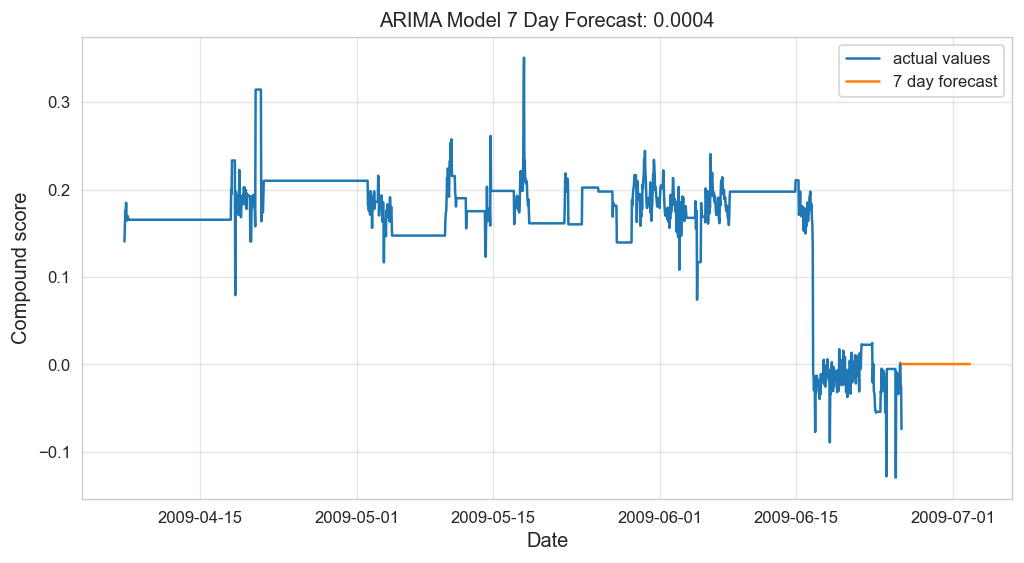

In [242]:
#plotting the predictions
plt.figure(figsize=(10,5))
plt.title(f'ARIMA Model 1 Day Forecast: {round(forecast_1d_arima.iloc[-1].forecast_sent, 4)}')
plt.xlabel('Date',fontsize=12)
plt.ylabel('Compound score', fontsize=12)
plt.plot(tweets_df_ts['compound'])
plt.plot(forecast_1d_arima)

plt.legend(['actual values','1 day forecast'], loc = 'upper right')
plt.grid(alpha=0.5)
plt.show()


plt.figure(figsize=(10,5))
plt.title(f'ARIMA Model 3 Day Forecast: {round(forecast_3d_arima.iloc[-1].forecast_sent, 4)}')
plt.xlabel('Date',fontsize=12)
plt.ylabel('Compound score', fontsize=12)
plt.plot(tweets_df_ts['compound'])
plt.plot(forecast_3d_arima)

plt.legend(['actual values','3 day forecast'], loc = 'upper right')
plt.grid(alpha=0.5)
plt.show()

plt.figure(figsize=(10,5))
plt.title(f'ARIMA Model 7 Day Forecast: {round(forecast_7d_arima.iloc[-1].forecast_sent, 4)}')
plt.xlabel('Date',fontsize=12)
plt.ylabel('Compound score', fontsize=12)
plt.plot(tweets_df_ts['compound'])
plt.plot(forecast_7d_arima)

plt.legend(['actual values','7 day forecast'], loc = 'upper right')
plt.grid(alpha=0.5)
plt.show()

### Looking at the forecasts at a smaller date range:

In [243]:
#defining function to create better x_ticks for visualisations, showing every 2nd date:
def get_x_ticks(orig_dataset, forecast_dataset):
    date_ticks = pd.DataFrame(((orig_dataset['compound'].iloc[1400:]).index).append(forecast_dataset.index))
    date_ticks['datetime'] = pd.to_datetime(date_ticks['datetime'])
    return date_ticks['datetime'].dt.date.unique()[::2]

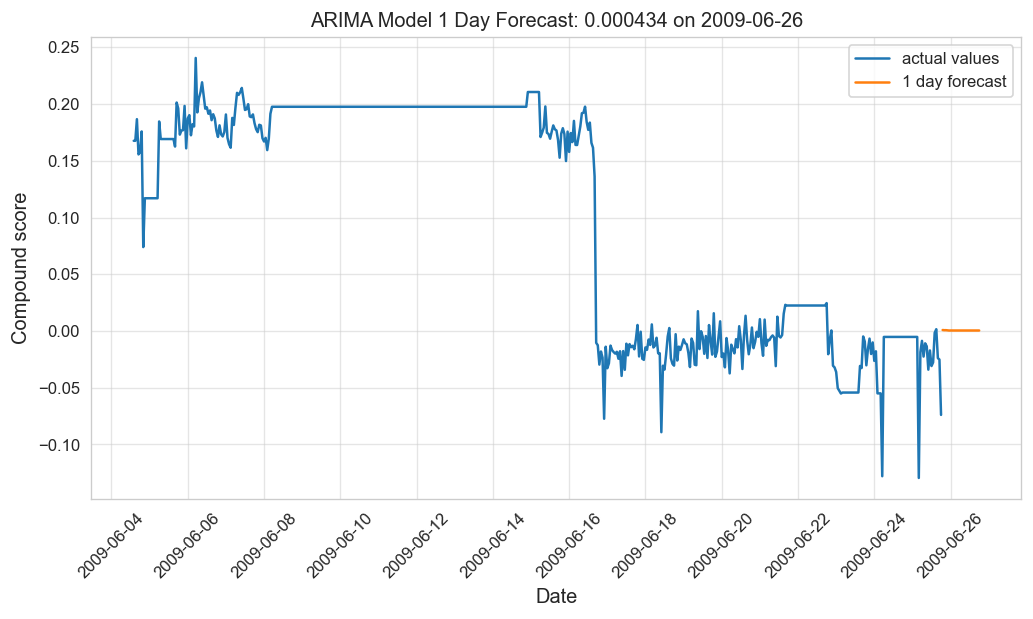

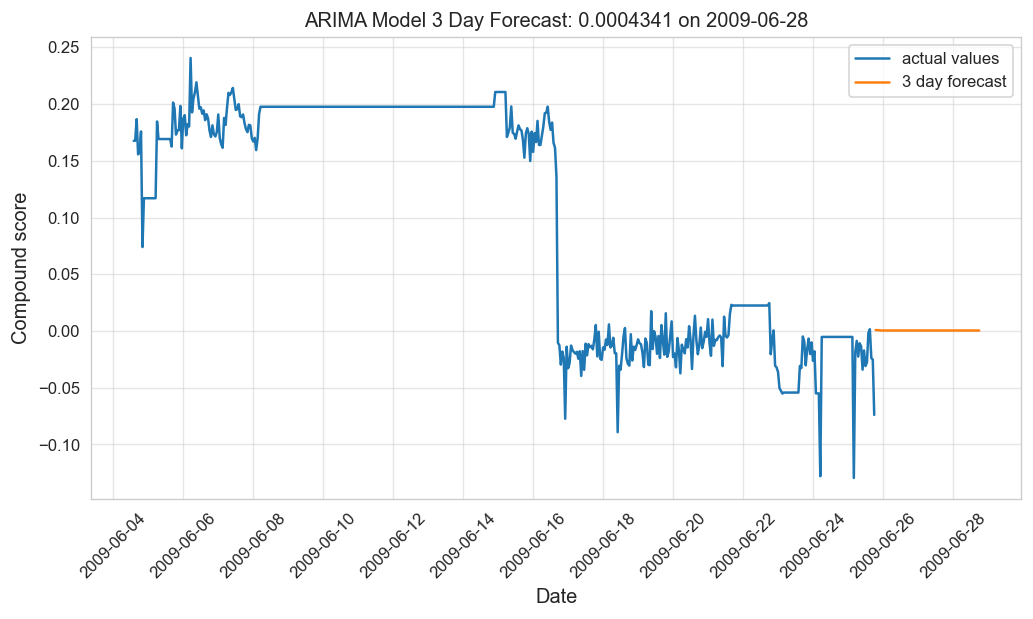

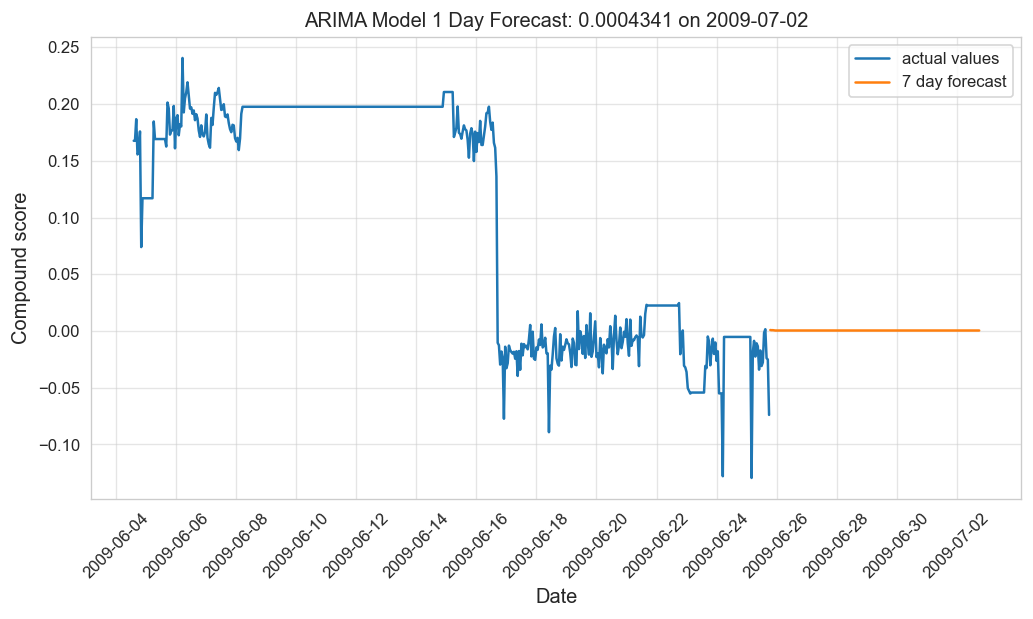

In [246]:
#plotting the predictions
#================1 Day==================#
plt.figure(figsize=(10,5))
_1d_date = str((forecast_1d_arima.iloc[-1].name).date())
plt.title(f'ARIMA Model 1 Day Forecast: {round(forecast_1d_arima.iloc[-1].forecast_sent, 6)} on {_1d_date}')
plt.xlabel('Date',fontsize=12)
plt.ylabel('Compound score', fontsize=12)
plt.plot(tweets_df_ts['compound'].iloc[1400:])
plt.plot(forecast_1d_arima)
plt.xticks(get_x_ticks(tweets_df_ts, forecast_1d_arima), rotation=45)
plt.legend(['actual values','1 day forecast'], loc = 'upper right')
plt.grid(alpha=0.5)
plt.show()

#================3 Days===================#

plt.figure(figsize=(10,5))
_3d_date = str((forecast_3d_arima.iloc[-1].name).date())
plt.title(f'ARIMA Model 3 Day Forecast: {round(forecast_3d_arima.iloc[-1].forecast_sent, 7)} on {_3d_date}')
plt.xlabel('Date',fontsize=12)
plt.ylabel('Compound score', fontsize=12)
plt.plot(tweets_df_ts['compound'].iloc[1400:])
plt.plot(forecast_3d_arima)
plt.xticks(get_x_ticks(tweets_df_ts, forecast_3d_arima), rotation=45)
plt.legend(['actual values','3 day forecast'], loc = 'upper right')
plt.grid(alpha=0.5)
plt.show()

#=================7 Days======================#

plt.figure(figsize=(10,5))
_7d_date = str((forecast_7d_arima.iloc[-1].name).date())
plt.title(f'ARIMA Model 1 Day Forecast: {round(forecast_7d_arima.iloc[-1].forecast_sent, 7)} on {_7d_date}')
plt.xlabel('Date',fontsize=12)
plt.ylabel('Compound score', fontsize=12)
plt.plot(tweets_df_ts['compound'].iloc[1400:])
plt.plot(forecast_7d_arima)
plt.xticks(get_x_ticks(tweets_df_ts, forecast_7d_arima), rotation=45)
plt.legend(['actual values','7 day forecast'], loc = 'upper right')
plt.grid(alpha=0.5)
plt.show()


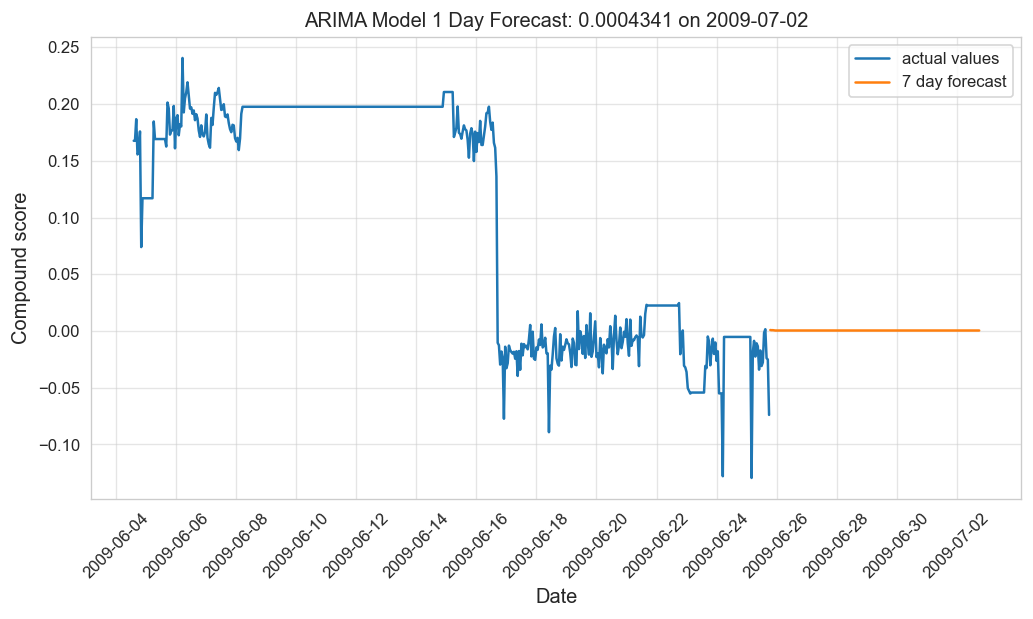

In [277]:

plt.figure(figsize=(10,5))
_7d_date = str((forecast_7d_arima.iloc[-1].name).date())
plt.title(f'ARIMA Model 1 Day Forecast: {round(forecast_7d_arima.iloc[-1].forecast_sent, 7)} on {_7d_date}')
plt.xlabel('Date',fontsize=12)
plt.ylabel('Compound score', fontsize=12)
plt.plot(tweets_df_ts['compound'].iloc[1400:])
plt.plot(forecast_7d_arima)
plt.xticks(get_x_ticks(tweets_df_ts, forecast_7d_arima), rotation=45)
plt.legend(['actual values','7 day forecast'], loc = 'upper right')
plt.grid(alpha=0.5)
plt.show()


# Section 5 : Exporting the LSTM + ARIMA forecasts for use on dashboard

In [308]:
forecast_1d_lstm= forecast_1d_lstm.rename(columns={'forecast_sent':'1d_lstm'})
forecast_3d_lstm= forecast_3d_lstm.rename(columns={'forecast_sent':'3d_lstm'})
forecast_7d_lstm= forecast_7d_lstm.rename(columns={'forecast_sent':'7d_lstm'})

In [249]:
forecast_1d_arima= forecast_1d_arima.rename(columns={'forecast_sent':'1d_arima'})
forecast_3d_arima= forecast_3d_arima.rename(columns={'forecast_sent':'3d_arima'})
forecast_7d_arima= forecast_7d_arima.rename(columns={'forecast_sent':'7d_arima'})

In [263]:
#merging models for same forecasting time ranges
forecast_1d = pd.merge(forecast_1d_lstm.reset_index(), forecast_1d_arima.reset_index())
forecast_3d = pd.merge(forecast_3d_lstm.reset_index(), forecast_3d_arima.reset_index())
forecast_7d = pd.merge(forecast_7d_lstm.reset_index(), forecast_7d_arima.reset_index())

In [349]:
#saving dataframes to csvs
forecast_1d.to_csv('_forecast_1d.csv')
forecast_3d.to_csv('_forecast_3d.csv')
forecast_7d.to_csv('_forecast_7d.csv')

In [265]:
#saving other dataframes for dashboard 
tweets_df_ts.to_csv('tweets_time_series.csv')
tweets_df.to_csv('tweets.csv')